# Phonebook Diver

This cookbook is create to be used in parallel with The Phone Book Diver project. It can be used to analyze the data.

###### To get started you must
(see section Basic Setup)
1. load the libraries
2. extinguish a database connection

## Basic Setup

Load libraries and connect to database

In [44]:
import os
import requests
import pymongo
from pymongo import MongoClient, UpdateOne
import numpy as np
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import time
import warnings
import helper

In [2]:
# Extinguish connection
MONGO_URI = 'mongodb://localhost:27017'

try:
    client = MongoClient(MONGO_URI)
    db = client.phonebookdiver
except pymongo.errors.ConnectionFailure as err:
    print(err)
else:
    print(f'CONNECTED to {MONGO_URI} {db.name}')
    collections = helper.get_phonebooks(db)
    pd.set_option('display.max_rows', 500)

CONNECTED to mongodb://localhost:27017 phonebookdiver


### Jupyter Notebook setup
View setup options and adjust as needed

In [21]:
pd.describe_option()

compute.use_bottleneck : bool
    Use the bottleneck library to accelerate if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
compute.use_numba : bool
    Use the numba engine option for select operations if it is installed,
    the default is False
    Valid values: False,True
    [default: False] [currently: False]
compute.use_numexpr : bool
    Use the numexpr library to accelerate computation if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
display.chop_threshold : float or None
    if set to a float value, all float values smaller then the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]
display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]
display.column_space No description available.
    [defa

In [232]:
pd.set_option('display.max_rows', 500)

#### Reset one or all options

In [23]:
pd.reset_option('display.max_rows')

# OR 

# pd.reset_option('all')

### Helper functions

Available helper functions are:

###### get_phonebooks(db)
- will return a list of all telephone books (not all collections)

###### elapsed_time(start, time.time())
- used to measure processing time for queries and other actions.

###### export_results(dataframe, collection, [value1, value2, ...], with_index)
- export results where collection and a list of values is used to define filename
 - first value from list (value[0]) also defines folder name 
- bool with_index defines if index will be saved to file

###### log(type, message)
- log information when processing data
 - type (string) can be:
 - -- 'INFO' - normal log info
 - -- 'WARNING' - to add an WARNING information to log
 - -- 'LB' - to add a linebreak

###### create_collection(db_obj, collection_name, dataframe, reset_index)
- create new collection from dataframe

###### create_index_on_fields(db_obj, collections_list, [field1, field2, ...])
- create index on field  in all telephone book collections


## Queries, Grouping and Aggregation

### Basic Queries
#### Single collection

In [228]:
# Define collection, keys and values
collection = '2018_Q3'
query_values = {
    'lastname': 'Müller',
    'firstname': 'Michael',
    'city': 'Berlin'
}

Please notice that find_one() will return only the first matching document, while find() will return a list of of all matching documents.

In [233]:
# Get first matching document
single_result = db[collection].find_one(query_values)
single_result

{'_id': 15961960,
 'lastname': 'Müller',
 'firstname': 'Michael',
 'phonenumber': '11650469',
 'city': 'Berlin',
 'area_code': '0151',
 'zip': '10243'}

In [235]:
# Get first matching document but only return defind fields
single_result = db[collection].find_one(query_values, {'_id': 0, 'zip': 1})
single_result

{'zip': '10243'}

In [237]:
# Get dataframe with ONE search value
start = time.time()
results_one = pd.DataFrame(db[collection].find({'lastname': query_values['lastname']}))
print(helper.elapsed_time(start, time.time()))
results_one
# processing time (first try SSD) '5.1397271156311035 seconds'

8.790425062179565 seconds


,_id,lastname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr,firstname
0,10304,Müller,67994012,Flensburg,0461,249..,NaN,NaN,NaN,NaN,NaN
1,10305,Müller,1826136,Flensburg,0461,24939,5,54.790445\t9.430528,Toosbüystr.,352522\t5,NaN
2,10306,Müller,36818,Flensburg,0461,24939,NaN,NaN,NaN,NaN,A.
3,10307,Müller,3217318,Flensburg,0172,24941,11,54.759180\t9.383450,Johann-Thomas-Lundbye-Weg,203475\t11,Anika
4,10309,Müller,1822078,Flensburg,0172,24939,51,54.803001\t9.417208,Bauer Landstr.,63952\t51,Annedore
...,...,...,...,...,...,...,...,...,...,...,...
138467,18650660,Müller,832754,Windischleuba,03447,04603,6C,51.012741\t12.469106,Luckaer Str.,243763\t6C,Hartmut
138468,18650661,Müller,839551,Windischleuba,03447,04603,3,50.974308\t12.486183,Schulstr.,324443\t3,Jürgen
138469,18650662,Müller,898795,Altenburg,03447,04600,13,51.002117\t12.466609,Am Schenkengraben,33417\t13,Maik
138470,18650663,Müller,839308,Windischleuba,03447,04603,15,51.022062\t12.469524,Otto-Engert-Str.,279850\t15,Mario


In [54]:
# Export above results to .csv file
helper.export_results(results_one, collection, query_values[:1], False)

In [238]:
# Get Dataframe with TWO search values
start = time.time()
results_two = pd.DataFrame(db[collection].find({'lastname': query_values['lastname'], 'firstname': query_values['firstname']}))
print(helper.elapsed_time(start, time.time()))
results_two

0.7163019180297852 seconds


,_id,lastname,street_number,firstname,phonenumber,coordinates,street,city,area_code,street_index_hnr,zip
0,10356,Müller,11B,Michael,5050180,54.818458\t9.475136,Twedter Holz,Flensburg,0461,355066\t11B,24944
1,41492,Müller,4A,Michael,396098,54.400700\t10.169370,Grüffkamp,Kiel,0431,146094\t4A,24159
2,41493,Müller,69A,Michael,697079,54.307582\t10.068989,Russeer Weg,Kiel,0431,310659\t69A,24111
3,81379,Müller,8,Michael,81888,53.851125\t10.662757,Berta-Wirthel-Ring,Lübeck,0451,69455\t8,23558
4,164177,Müller,12A,Michael,181398,53.748991\t10.454410,Waldstr.,Groß Boden,04539,370386\t12A,23847
...,...,...,...,...,...,...,...,...,...,...,...
1705,18581899,Müller,14,Michael,379121,51.041888\t11.816713,Grüne Weide,Schkölen,036694,146299\t14,07619
1706,18584572,Müller,56,Michael,2836088,50.409234\t11.809626,Jägerstr.,Hirschberg,0170,200851\t56,07927
1707,18584573,Müller,56,Michael,43250,50.409234\t11.809626,Jägerstr.,Hirschberg,036644,200851\t56,07927
1708,18592834,Müller,10,Michael,416633,50.696770\t11.560156,Am Krötenberg,Pößneck,03647,25240\t10,07381


In [115]:
# Export above results to .csv file
helper.export_results(results_two, collection, query_values[:2], False)

In [240]:
# Get Dataframe with THREE search values
start = time.time()
results_three = pd.DataFrame(db[collection].find({'lastname': query_values['lastname'], 'firstname': query_values['firstname'], 'city': query_values['city']}))
print(helper.elapsed_time(start, time.time()))
# 180.79311847686768 seconds for Müller, Michael, Berlin
# 11.972640037536621 seconds second attempt
# 1.4402179718017578 seconds third attempt

# '10.854856014251709 seconds' (first time SSD)
results_three

0.41314005851745605 seconds


,_id,lastname,firstname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr
0,15961960,Müller,Michael,11650469,Berlin,0151,10243,NaN,NaN,NaN,NaN
1,15961961,Müller,Michael,9639504,Berlin,0170,13125,NaN,NaN,NaN,NaN
2,15961962,Müller,Michael,235066-0,Berlin,030,10779,NaN,NaN,NaN,NaN
3,15961963,Müller,Michael,3365095,Berlin,030,13587,NaN,NaN,NaN,NaN
4,15961966,Müller,Michael,65263810,Berlin,030,12555,15,52.448646\t13.583252,Am Krusenick,25385\t15
5,15961967,Müller,Michael,1225480,Berlin,0179,13055,11,52.536082\t13.505087,Arendsweg,51103\t11
6,15961968,Müller,Michael,4211241,Berlin,0172,10439,69,52.551472\t13.401656,Behmstr.,65467\t69
7,15961969,Müller,Michael,4123182,Berlin,030,13403,15,52.566107\t13.323618,Berenhorststr.,67819\t15
8,15961970,Müller,Michael,6921482,Berlin,030,10961,3,52.489561\t13.387880,Bergmannstr.,68357\t3
9,15961971,Müller,Michael,23638923,Berlin,030,10783,66,52.496412\t13.367179,Bülowstr.,84603\t66


In [173]:
# Sort results (use 'inplace=True' to change Dataframe)
results_three.sort_values(by=['zip', 'street', 'street_number'], ascending=True)

,_id,lastname,firstname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr
0,15961960,Müller,Michael,11650469,Berlin,0151,10243,NaN,NaN,NaN,NaN
6,15961968,Müller,Michael,4211241,Berlin,0172,10439,69,52.551472\t13.401656,Behmstr.,65467\t69
28,15961990,Müller,Michael,3947356,Berlin,030,10557,18C,52.526263\t13.360183,Seydlitzstr.,329396\t18C
15,15961977,Müller,Michael,34787834,Berlin,030,10585,9,52.515392\t13.305295,Haubachstr.,157034\t9
11,15961973,Müller,Michael,3247332,Berlin,030,10629,10,52.501193\t13.303372,Dahlmannstr.,92636\t10
18,15961980,Müller,Michael,8835106,Berlin,030,10707,171,52.499695\t13.309319,Kurfürstendamm,230633\t171
2,15961962,Müller,Michael,235066-0,Berlin,030,10779,NaN,NaN,NaN,NaN
9,15961971,Müller,Michael,23638923,Berlin,030,10783,66,52.496412\t13.367179,Bülowstr.,84603\t66
8,15961970,Müller,Michael,6921482,Berlin,030,10961,3,52.489561\t13.387880,Bergmannstr.,68357\t3
20,15961982,Müller,Michael,81828331,Berlin,030,12101,19,52.482550\t13.381882,Manfred-von-Richthofen-Str.,248135\t19


In [117]:
# Export above results to .csv file
helper.export_results(results_three, collection, query_values[:3], False)

### Value Counts

In [242]:
# top 50 cities with Müller
results = pd.DataFrame(db['2018_Q3'].find({'lastname': 'Müller'}, {'_id': 0, 'city':1, 'zip':1}))
# results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
results.value_counts('city').head(100)
# results['city'].value_counts().head(100)

city
Berlin                    2764
München                   1342
Köln                      1246
Hamburg                   1116
Nürnberg                   737
Frankfurt                  723
Stuttgart                  668
Dresden                    655
Düsseldorf                 604
Leipzig                    603
Bremen                     554
Essen                      508
Hannover                   482
Duisburg                   471
Dortmund                   441
Chemnitz                   402
Saarbrücken                382
Neustadt                   382
Karlsruhe                  376
Wuppertal                  363
Bonn                       362
Mannheim                   343
Wiesbaden                  342
Augsburg                   317
Braunschweig               316
Bochum                     311
Mainz                      308
Bielefeld                  286
Magdeburg                  284
Siegen                     279
Neunkirchen                277
Halle                      271
Fre

In [244]:
# results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
# results['zip'].value_counts().head(100)
results.value_counts(['zip']).head(100)
# results.value_counts(['zip', 'city']).head(100)

zip  
76437    220
27404    149
66606    140
69469    133
55743    132
77704    127
65719    119
37308    116
66346    115
66386    115
55758    115
96450    115
57223    114
36381    114
37339    113
51789    113
36391    111
50354    108
07407    106
56412    104
76829    104
66482    104
04668    103
1....    102
65510    100
66333     99
67227     98
96528     98
65428     94
74722     94
66679     93
66822     93
57234     93
27432     92
09337     92
52249     92
91126     92
5....     91
99734     90
63303     89
87700     89
71229     89
78628     88
53773     88
72108     88
95326     87
66424     87
96317     87
96515     87
50226     87
76275     86
53639     86
66701     86
40764     85
04600     85
07381     84
74523     84
50374     84
50321     83
68723     83
35080     83
66740     83
56626     83
99974     82
76646     81
66583     81
61440     81
51515     81
66571     80
50259     80
36396     80
66851     80
65779     79
57250     79
66540     79
67346     79
56743 

In [243]:
results.value_counts(['zip', 'city']).head(100)

zip    city                 
76437  Rastatt                  220
66606  St. Wendel               139
69469  Weinheim                 133
77704  Oberkirch                127
55743  Idar-Oberstein           125
65719  Hofheim                  119
66386  St. Ingbert              115
66346  Püttlingen               115
96450  Coburg                   115
57223  Kreuztal                 114
36381  Schlüchtern              112
51789  Lindlar                  111
36391  Sinntal                  111
50354  Hürth                    108
66482  Zweibrücken              104
76829  Landau                   102
1....  Berlin                   102
66333  Völklingen                99
67227  Frankenthal               98
65428  Rüsselsheim am Main       94
66679  Losheim am See            93
66822  Lebach                    93
74722  Buchen                    93
57234  Wilnsdorf                 93
52249  Eschweiler                92
5....  Köln                      91
99734  Nordhausen                90

In [245]:
# results = pd.DataFrame(db['2018_Q3'].find({'lastname': 'Müller'}))
# results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
results['city'].value_counts(normalize=True)

Berlin            0.019965
München           0.009694
Köln              0.009000
Hamburg           0.008061
Nürnberg          0.005323
                    ...   
Erbach Donau      0.000007
Biebern           0.000007
Arholzen          0.000007
Unterhadermark    0.000007
Schönwalde        0.000007
Name: city, Length: 9558, dtype: float64

In [246]:
results = pd.DataFrame(db['2018_Q3'].find({'lastname': 'Müller', 'firstname': 'Michael', 'city': 'Berlin'}, {'_id': 0, 'city': 1, 'zip': 1}))
# results = pd.read_csv(r'./Müller/2018_Q3_Müller_Michael_Berlin.csv')
results

,city,zip
0,Berlin,10243
1,Berlin,13125
2,Berlin,10779
3,Berlin,13587
4,Berlin,12555
5,Berlin,13055
6,Berlin,10439
7,Berlin,13403
8,Berlin,10961
9,Berlin,10783


In [247]:
results['zip'].value_counts()

13125    2
12207    2
12307    1
13055    1
12279    1
10629    1
10783    1
12101    1
10439    1
10585    1
10707    1
13127    1
12555    1
10557    1
14059    1
10243    1
13587    1
14055    1
12355    1
12357    1
10779    1
12165    1
13591    1
13505    1
14163    1
13403    1
12209    1
10961    1
Name: zip, dtype: int64

#### Filter queried data by using regex string

In [5]:
# TEST
df = pd.DataFrame(db['2015_Q3'].find({'lastname': {'$regex': 'Prof\\.'}}))

In [6]:
df.head(500)

,_id,zip,street_index_hnr,street,area_code,city,phonenumber,coordinates,street_number,lastname,firstname
0,47957,24113,84224\t1,Brüggerfelde,0431,Kiel,Fax 649862,54.292845\t10.112597,1,A.S.B. Prof. Weber-Haus Kieler Stadtkloster,NaN
1,14462604,89073,64978\t37,Basteistr.,0731,Ulm,22252,48.400621\t10.003046,37,AAB Augenaerzte im Basteicenter Spraul Prof.Dr...,NaN
2,21584302,04329,160098\t9,Haselstr.,0341,Leipzig,Tel/Fax 2519214,51.349933\t12.449981,9,ABL Architektur-und Bauplanungsbüro Prof.Dr.-I...,NaN
3,22438889,99425,384743\t3,Weimarische Str.,03643,Weimar,502736,50.959653\t11.346594,3,ABRAXAS. Büro für kreative Leistungen Prof. Dr...,NaN
4,19213401,13189,52138\t45-49,Arkonastr.,030,Berlin,467092-0,NaN,45-49,ADA Acoustic Design Ahnert Prof. Dr.-Ing. habi...,NaN
5,19213402,13189,52138\t45-49,Arkonastr.,030,Berlin,Fax 467092-20,NaN,45-49,ADA Acoustic Prof. Dr.-Ing. habil. W. Ahnert,NaN
6,17617054,90542,1381\t27,Adam-Kraft-Str.,0179,Eckental,6925974,49.591837\t11.211424,27,ADI-Consult Prof. Dr. Laumann,NaN
7,17890208,97078,320989\t11,Sandweg,0931,Würzburg,284770,49.807686\t9.960080,11,AGBN Arbeitsgemeinschaft Bayer. Notärzte e.V. ...,NaN
8,17890209,97078,320989\t11,Sandweg,0931,Würzburg,Fax 284746,49.807686\t9.960080,11,AGBN Arbeitsgemeinschaft Bayer. Notärzte e.V. ...,NaN
9,14862369,80995,141182\t11,Glasstr.,089,München,6929026,48.226124\t11.524305,11,ARC Prof. Dr. Andrea Raab,NaN


In [97]:
# filter distinct city names
data_df = pd.read_csv(r'./archive/2018_Q3_city_count_orderedByCity.csv')
data_df[data_df.city.str.contains('Berlin', regex= True, na=False)]

,city,count
1883,Berlin,436115
1884,Berlinchen,1
1885,Berlingen,106
1886,Berlingen Eifel,4
1887,Berlingerode,338
1904,Bernau bei Berlin,4141
15381,Neuenhagen b Berlin,2421
15382,Neuenhagen bei Berlin,1
19279,Rüdersdorf bei Berlin,47
20430,Schöneiche bei Berlin,1650


### Grouping

In [41]:
# grouping
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
city_grp = results.groupby(['city'])
city_grp.get_group('Berlin')

,Unnamed: 0,_id,lastname,phonenumber,city,area_code,zip,street_number,coordinates,street,street_index_hnr,firstname
111788,111788,15711735,Müller,6167528-60,Berlin,30.0,10967,64,52.488491\t13.425395,Kottbusser Damm,225480\t64,Peter
111789,111789,15946017,Müller,3332028,Berlin,30.0,13597,1,52.537718\t13.203519,Moritzstr.,259528\t1,Heinrich
111790,111790,15946019,Müller,28391477,Berlin,30.0,10115,12,52.528489\t13.380163,Hessische Str.,167105\t12,Lothar A.
111791,111791,15946021,Müller,8831576,Berlin,30.0,10719,21,52.500687\t13.330412,Joachimsthaler Str.,202336\t21,V.
111792,111792,15959949,Müller,97730510,Berlin,160.0,1....,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
114547,114547,15962778,Müller,7745836,Berlin,30.0,12247,36,52.437822\t13.355653,Alt-Lankwitz,6021\t36,Wolfram
114548,114548,15962779,Müller,3232751,Berlin,30.0,10711,8,52.500217\t13.298313,Hektorstr.,162535\t8,Wolfram
114549,114549,15962780,Müller,8184881,Berlin,30.0,14167,1,52.430227\t13.261167,Herbergerweg,164257\t1,Wolfram
114550,114550,15962781,Müller,7922902,Berlin,30.0,12279,29,52.409750\t13.351436,Waldsassener Str.,370284\t29,Wolfram


In [42]:
city_grp.get_group('Berlin')['zip'].value_counts()

1....    102
10717     31
12555     31
13503     31
13591     29
13187     27
12353     27
12349     26
12203     26
13125     26
12355     26
13507     25
12107     24
12209     24
12487     23
13467     23
13593     23
10319     23
12623     23
12621     22
12683     22
12205     22
13595     22
12587     22
12163     22
12524     21
13469     21
14165     21
12207     21
10315     21
13156     21
12679     20
14167     20
12681     20
14057     20
14169     20
12351     20
13589     20
10179     20
13407     20
13509     20
12249     19
10243     19
12359     18
12247     18
13627     18
12105     18
10961     18
10407     18
12157     18
10119     18
10318     18
12169     17
13055     17
12589     17
10965     17
10249     17
14052     17
13587     17
13465     17
13629     17
12161     17
10367     17
12099     17
13053     17
13353     17
13439     16
10247     16
12526     16
12109     16
13088     16
14129     16
14059     16
10245     16
12167     15
10997     15
13357     15

#### Value counts

In [4]:
# most common firstname for Müller (Germany)
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
results['firstname'].value_counts().head(50)

Peter         2226
Wolfgang      2179
Thomas        1829
Klaus         1779
Manfred       1758
Werner        1719
Michael       1710
Gerhard       1568
Helmut        1496
Horst         1456
Jürgen        1442
Andreas       1412
Heinz         1398
Dieter        1294
Bernd         1246
Hans          1221
Günter        1136
Walter        1126
Frank         1118
Herbert       1007
Josef         1006
Karl-Heinz     924
Karl           856
Stefan         856
Uwe            818
Rolf           812
Martin         801
Christian      793
Hermann        769
Kurt           751
Rudolf         710
Siegfried      703
Rainer         702
Matthias       693
Roland         687
Franz          672
Joachim        647
Gerd           642
Ralf           615
Harald         607
Heinrich       603
Alfred         603
Jörg           600
Georg          599
Norbert        593
Bernhard       590
Lothar         577
Ursula         573
Reinhard       569
Erich          567
Name: firstname, dtype: int64

In [21]:
# using filters (f)
results = pd.read_csv(r'./Müller/2018_Q3_Müller.csv')
f = results['city'] == 'Berlin'
results.loc[f]['firstname'].value_counts().head(20)

Wolfgang        60
Peter           58
Klaus           52
Horst           52
Andreas         52
Thomas          44
Manfred         40
Gerhard         39
Bernd           34
Werner          31
Michael         30
Christian       29
Dieter          29
Hans-Joachim    26
Jürgen          26
Günter          25
Frank           25
Renate          23
Joachim         23
Gabriele        22
Name: firstname, dtype: int64

In [24]:
results = pd.read_csv(r'./Müller/2001_Q1_Müller.csv')
results['zip'].value_counts(normalize=True)

1....    0.001336
76437    0.001315
2....    0.001036
55743    0.000886
66606    0.000865
           ...   
0762.    0.000003
94158    0.000003
86574    0.000003
0168.    0.000003
3570.    0.000003
Name: zip, Length: 9702, dtype: float64

In [44]:
start = time.time()
# result_zips = pd.DataFrame(db['2018_Q3'].find({}, {'zip': 1, 'city': 1}))
result_zips = pd.read_csv(r'./archive/2018_Q3_all_zips_cities.csv')
helper.elapsed_time(start, time.time())
# '331.52798795700073 seconds' (SSD)

'4.070561170578003 seconds'

In [26]:
result_zips.to_csv(r'./2018_Q3_all_zips_cities.csv')
'Done'

In [48]:
# number of entries by city
# result_zips['city'].value_counts()
result_zips.value_counts(['city']).head(100)

city                  
Berlin                    436115
Hamburg                   272888
München                   271946
Köln                      180821
Frankfurt                 113867
Düsseldorf                113234
Stuttgart                 106222
Nürnberg                   98622
Essen                      98271
Bremen                     97837
Dortmund                   90103
Hannover                   86168
Duisburg                   77240
Dresden                    70958
Leipzig                    64846
Wuppertal                  63887
Bielefeld                  62345
Bochum                     61636
Bonn                       61124
Münster                    59307
Karlsruhe                  54586
Mannheim                   50876
Augsburg                   50639
Wiesbaden                  50538
Braunschweig               48257
Mönchengladbach            47505
Aachen                     45368
Krefeld                    42637
Neustadt                   42322
Freiburg            

In [47]:
# number of entries by zip
# result_zips['zip'].value_counts()
result_zips.value_counts(['zip'])

zip  
1....    25365
2....    15035
8....    13682
5....    13006
91126    11618
         ...  
70559        1
70602        1
70745        1
70752        1
57622        1
Length: 11837, dtype: int64

#### Find differences in dataframes

In [36]:
data_ln = list(db['2018_Q3'].find({'zip': None, 'city': None, 'street': None, 'lastname':{'$exists':True}}))
len(data_ln)

42118

In [41]:
data_fn = list(db['2018_Q1'].find({'zip': None, 'city': None, 'street': None, 'firstname':{'$exists':True}}))
len(data_fn)

2303

In [40]:
data_fn_ln = list(db['2018_Q1'].find({'zip': None, 'city': None, 'street': None, 'firstname':{'$exists':True}, 'lastname':{'$exists':True}}))
len(data_fn_ln)

2303

Two dataframes with same length from similar query. What are the differences?

In [42]:
diff_df = pd.concat([pd.DataFrame(data_fn),pd.DataFrame(data_fn_ln)]).drop_duplicates(keep=False)
diff_df

,_id,lastname,firstname,phonenumber,area_code


### Multiple Collections

In [3]:
# Define collection, keys and values
query_keys = ['lastname', 'firstname', 'city']
query_values = ['Müller', 'Michael', 'Berlin']

In [23]:
# query and export name over all collections into multiple files
start = time.time()
# results = pd.DataFrame({})
for c in collections:
    df = pd.DataFrame(db[c].find({query_keys[0]: query_values[0]}))
    df['collection'] = c
    helper.export_results(df, c, query_values[:1], False)
    # TODO add column and collection marker
    # results.append(df, ignore_index=True)
helper.elapsed_time(start, time.time())
# processing time 2828.799796819687 seconds (HDD > 47 minutes)
# processing time 405.6872320175171 seconds (SSD < 7 minutes)
# results

'405.6872320175171 seconds'

In [189]:
# query and export name over all collections into one file
start = time.time()
result_frames = []
for c in collections:
    df = pd.DataFrame(db[c].find({query_keys[0]: query_values[0]}))
    df['collection'] = c
    result_frames.append(df)
results = pd.concat(result_frames, ignore_index=True)
results.to_csv(r'./Müller/Müller_all_in_one.csv')
helper.elapsed_time(start, time.time())

# processing time 17980.681665420532 seconds (5 hours) - filesize: 1.29 GB

'17980.681665420532 seconds'

In [131]:
count = 0
for c in collections:
    count += len(list(db[c].find({'lastname': 'Schütz'})))
print(f'Total count for lastname Schütz => {count}')

Total count for lastname Schütz => 562706


#### Trace specific record

###### Find record by collection and _id

In [4]:
def get_record_by_id(collection, id):
    return db[collection].find_one({'_id': id})

In [5]:
record = get_record_by_id('2018_Q3', 18650787)
record

{'_id': 18650787, 'phonenumber': 'Fax 850-444', 'area_code': '03447'}

###### Trace record by area_code and phone_nr over all collections

In [7]:
record['area_code']

'03447'

In [71]:
def trace_phonenr(area_code, phone_nr):
    if len(collections) <= 0: return 'No collections available'
    records = []
    for  c in collections:
        record = db[c].find_one({'area_code': area_code, 'phonenumber': {'$regex': phone_nr}})
        if record is not None:
            record['collection'] = c
            records.append(record)

    return records

In [214]:
# traced_nr = trace_phonenr('05245', '922811')
# traced_nr = trace_phonenr(record['area_code'][0], record['phonenumber'][0])
# traced_nr = trace_phonenr('03447', 'Fax 850-444')
# traced_nr = trace_phonenr('0461', 'Fax 50323-23')
# traced_nr = trace_phonenr('0461','Fax 93738')
# traced_nr = trace_phonenr('0461','93738')
# traced_nr = trace_phonenr('0451', '47000-16') # ? 
traced_nr = trace_phonenr('04541', 'Fax 89908-8')
pd.DataFrame(traced_nr)

,_id,firstname,phonenumber,area_code,collection
0,427139,Michael,Fax 89908-8,04541,2000_Q1
1,421188,Michael,Fax 89908-8,04541,2000_Q3
2,417315,Michael,Fax 89908-8,04541,2001_Q1
3,413968,Michael,Fax 89908-8,04541,2001_Q2
4,402903,Michael,Fax 89908-8,04541,2001_Q3
5,401568,Michael,Fax 89908-8,04541,2001_Q4
6,397462,Michael,Fax 89908-8,04541,2002_Q1
7,390911,Michael,Fax 89908-8,04541,2002_Q3
8,386247,Michael,Fax 89908-8,04541,2003_Q1
9,377567,Michael,Fax 89908-8,04541,2003_Q3


###### Trace record by address

In [10]:
def trace_address(zip, city, street, street_nr):
    if len(collections) <= 0: return 'No collections available'
    records = []
    query_values = {}
    if zip: query_values['zip'] = zip
    if city: query_values['city'] = city
    if street: query_values['street'] = street
    if street_nr: query_values['street_number'] = street_nr
    
    for  c in collections:
        record = db[c].find_one(query_values)
        if record:
            record['collection'] = c
            records.append(record)

    return records

In [15]:
traced_address = trace_address('12459', None, 'Wilhelminenhofstr.', '75A')
pd.DataFrame(traced_address)

,_id,street_index_hnr,zip,coordinates,city,firstname,street,phonenumber,street_number,area_code,lastname,collection
0,23007638,389798\t75A,12459,52.457004\t13.527605,Berlin,Karin,Wilhelminenhofstr.,5351693,75A,030,Backhaus,2010_Q3
1,22685236,391292\t75A,12459,52.457004\t13.527605,Berlin,Karin,Wilhelminenhofstr.,5351693,75A,030,Backhaus,2011_Q1
2,22365591,392737\t75A,12459,52.457004\t13.527605,Berlin,Karin,Wilhelminenhofstr.,5351693,75A,030,Backhaus,2011_Q3
3,21878997,393301\t75A,12459,52.457012\t13.527650,Berlin,Karin,Wilhelminenhofstr.,5351693,75A,030,Backhaus,2012_Q1
4,21816150,393701\t75A,12459,52.457004\t13.527605,Berlin,Karin,Wilhelminenhofstr.,5351693,75A,030,Backhaus,2012_Q3
5,21631251,393687\t75A,12459,52.457216\t13.527799,Berlin,NaN,Wilhelminenhofstr.,383782-0,75A,030,GA Netztechnik GmbH,2013_Q1
6,21256353,392748\t75A,12459,52.457216\t13.527799,Berlin,NaN,Wilhelminenhofstr.,383782-0,75A,030,GA Netztechnik GmbH,2013_Q3
7,20970468,392934\t75A,12459,52.457216\t13.527799,Berlin,NaN,Wilhelminenhofstr.,383782-0,75A,030,GA Netztechnik GmbH,2014_Q1
8,20285853,392801\t75A,12459,52.457216\t13.527799,Berlin,NaN,Wilhelminenhofstr.,383782-0,75A,030,GA Netztechnik GmbH,2014_Q3
9,19871042,393193\t75A,12459,52.457216\t13.527799,Berlin,NaN,Wilhelminenhofstr.,383782-0,75A,030,GA Netztechnik GmbH,2015_Q1


## Statistics (collecting numbers)

### Telephone book overview

In [15]:
# Total entries overview
start = time.time()
overview = {}
for c in collections:
    overview[c] = db[c].count_documents({})
processing_time_overview = helper.elapsed_time(start, time.time())
# '3333.12650346756 seconds 'processing time (2nd time NAS, first time > 2.5h)
# '1742.2622501850128 seconds' processing time (SSD first attempt - 29 minutes)
processing_time_overview

In [19]:
# Output collection overview
overview

,year,total_entries
0,1992_Q2,29874373
1,1995_Q0,33945932
2,1996_Q0,34189903
3,1996_Q1,34218752
4,1997_Q1,34630715
5,1997_Q3,34737798
6,1998_Q1,34996369
7,1998_Q3,36070875
8,1999_Q1,36071839
9,1999_Q3,36612030


In [1]:
# Export
pd_overview = pd.DataFrame.from_dict(overview, orient='index')
pd_overview.to_csv(r'./stats/collection_total_count.csv')

### Ranking
Rank common names and location data

In [8]:
def get_top_n(n_rows, path, singular, plural):
    if len(singular) != len(plural): return 'FAIL: List of singular and plural cannot have different length.'
    top_n = []
    for filename in os.listdir(path):
        if 'value_counts.csv' in filename:
            n_data = pd.read_csv(r'./' + path + filename, nrows=n_rows).to_dict('list')
            collection = filename[:7]
            n_dict = [dict for dict in top_n if dict['collection'] == collection]
            for i, value in enumerate(singular):
                if value in filename:
                    if n_dict:
                        n_dict[0][plural[i]] = n_data
                    else:
                        top_n.append({'collection': collection, plural[i]: n_data})
    return sorted(top_n, key=lambda k: k['collection']) 


In [9]:
def build_ranking(top_n, _value, by_count):
    ranking = {}
    for n in top_n:
        if _value == 'city':
            values = n['cities']['unique_' + _value]
            count = n['cities']['counts']
        elif _value == 'combo':
            ln = n[_value + 's']['lastname']
            fn = n[_value + 's']['firstname']
            count = n[_value + 's']['count']
            values = []
            for i, l in enumerate(ln):
                values.append(f'{ln[i]}, {fn[i]}')
        else:
            values = n[_value + 's']['unique_' + _value]
            count = n[_value + 's']['counts']
        if by_count:
            for i, value in enumerate(values):
                if value in ranking:
                    ranking[value] += count[i]
                else:
                    ranking[value] = count[i]
        else:
            for i, value in enumerate(values):
                if value in ranking:
                    ranking[value] += (len(values) - i)
                else:
                    ranking[value] = (len(values) - i)
    return {k: ranking[k] for k in sorted(ranking, key=ranking.get, reverse=True)}

#### Names

Fetch value_counts for first- and lastname of each telephone book, then export to csv.  
Underneath can be found an extraction function to find top n names.
Ranking is listed at the end of this section.

In [10]:
def value_counts_from_df(collection, names, value):
    val_counts_names_df = pd.DataFrame(names.value_counts(value))
    value_counts_names_df = val_counts_names_df.reset_index()
    value_counts_names_df.columns = [f'unique_{value}', 'count']
    helper.export_results(value_counts_names_df, collection, ['all_names', value,'value_counts'], False)
    print(f'{collection} {value} {helper.elapsed_time(start, time.time())}')

In [11]:
# used to value count name combo
def value_counts_combined(collection, names):
    val_counts_names_df = pd.DataFrame(names.value_counts(['lastname', 'firstname']))
    value_counts_names_df = val_counts_names_df.reset_index()
    value_counts_names_df.columns = ['lastname', 'firstname', 'count']
    helper.export_results(value_counts_names_df, collection, ['all_names_combo', 'value_counts'], False)
    print(f'{collection} name_combo {helper.elapsed_time(start, time.time())}')

In [7]:
_start = time.time()
values = ['lastname', 'firstname']
for c in collections:
    start = time.time()
    names = pd.DataFrame(db[c].find({}, {'_id':0, values[0]:1, values[1]:1}))
    msg = f'{c} query time: {helper.elapsed_time(start, time.time())}'
    helper.log('INFO',  msg)
    print(msg)
    # process values
    # value_counts_from_df(c, names, values[0])
    # value_counts_from_df(c, names, values[1])
    value_counts_combined(c, names)

final_msg = f'Total processing time {helper.elapsed_time(_start, time.time())}'
helper.log('INFO',  final_msg)
print(final_msg)

# FAIL: exporting all names
# 1992_Q2 query time: 783.8630819320679 seconds
# 1992_Q2 lastname 1093.9235508441925 seconds
# 1992_Q2 firstname 1307.7671768665314 seconds
# 1995_Q0 query time: 2374.8568110466003 seconds
# 1995_Q0 lastname 3432.5842349529266 seconds
# 1995_Q0 firstname 3819.1937091350555 seconds
# 1996_Q0 query time: 5082.24489402771 seconds

# SUCCESS
# total run 65955.79109597206 seconds (> 18.32 h)
# see log file for more details

1992_Q2 query time: 24.486587500572206 minutes
1992_Q2 name_combo 35.14475456476212 minutes
1995_Q0 query time: 36.027231283982594 minutes
1995_Q0 name_combo 49.44091482162476 minutes
1996_Q0 query time: 33.49595772027969 minutes
1996_Q0 name_combo 48.72608613570531 minutes
1996_Q1 query time: 37.18646763563156 minutes
1996_Q1 name_combo 49.62070165077845 minutes
1997_Q1 query time: 36.01334931453069 minutes
1997_Q1 name_combo 49.484857217470804 minutes
1997_Q3 query time: 36.055945960680646 minutes
1997_Q3 name_combo 49.70712814728419 minutes
1998_Q1 query time: 36.87215639750163 minutes
1998_Q1 name_combo 51.21622256835302 minutes
1998_Q3 query time: 38.64096183776856 minutes
1998_Q3 name_combo 53.38540868361791 minutes
1999_Q1 query time: 38.4818400700887 minutes
1999_Q1 name_combo 56.49159495433172 minutes
1999_Q3 query time: 39.09597133398056 minutes
1999_Q3 name_combo 55.29225758314133 minutes
2000_Q1 query time: 39.436876153945924 minutes
2000_Q1 name_combo 58.56618855396906 min

###### Get top n names from all collections

In [12]:
top_n_names = get_top_n(100000, 'stats/all_names/', ['lastname', 'firstname'], ['lastnames', 'firstnames'])

In [13]:
top_n_name_combos = get_top_n(100000, 'stats/all_names_combo/', ['combo'], ['combos'])

###### Show specific telephone book edition

In [59]:
collection = '2018_Q3'
[dict for dict in top_n_names if dict['collection'] == collection]

[{'collection': '2018_Q3',
  'lastnames': {'unique_lastname': ['Müller',
    'Schmidt',
    'Schneider',
    'Fischer',
    'Weber',
    'Meyer',
    'Wagner',
    'Becker',
    'Hoffmann',
    'Schulz',
    'Bauer',
    'Schäfer',
    'Koch',
    'Richter',
    'Klein',
    'Wolf',
    'Schröder',
    'Schwarz',
    'Hofmann',
    'Braun',
    'Neumann',
    'Schmitt',
    'Zimmermann',
    'Schmid',
    'Hartmann',
    'Maier',
    'Meier',
    'Werner',
    'Huber',
    'Schmitz',
    'Lange',
    'Krüger',
    'Mayer',
    'Krause',
    'König',
    'Lehmann',
    'Walter',
    'Herrmann',
    'Köhler',
    'Lang',
    'Fuchs',
    'Kaiser',
    'Schulze',
    'Weiß',
    'Peters',
    'Jung',
    'Möller',
    'Scholz',
    'Keller',
    'Roth',
    'Hahn',
    'Frank',
    'Beck',
    'Vogel',
    'Friedrich',
    'SCHLUESEL DEUTSCHE-SCHLÜSSELDIENST-ZENTRALE Rufumleitung z. Firmensitz n. Zug eK',
    '0 1 7 3 - 4 5 6 7 8 9 0 SCHLOSS-, SCHLÜSSELNOTDIENST 365 TAGE Schaefer e.K.',
 

###### Create ranking

In [124]:
# Ranking by rank per edition LAST NAME
# build_ranking(top_n_names, 'lastname', False)
pd.DataFrame(build_ranking(top_n_names, 'lastname', False).items(), columns=['Lastname', 'Score']).head(100)

,Lastname,Score
0,Müller,5000000
1,Schmidt,4999950
2,Schneider,4999900
3,Fischer,4999850
4,Weber,4999794
5,Meyer,4999756
6,Wagner,4999699
7,Becker,4999637
8,Schulz,4999598
9,Hoffmann,4999564


In [119]:
# Ranking by count LAST NAME
# build_ranking(top_n_names, 'lastname', True)
pd.DataFrame(build_ranking(top_n_names, 'lastname', True).items(), columns=['Lastname', 'Count']).head(100)

,Lastname,Count
0,Müller,11801881
1,Schmidt,8665866
2,Schneider,5331829
3,Fischer,4511058
4,Weber,3974611
5,Meyer,3854084
6,Wagner,3666368
7,Becker,3393652
8,Schulz,3325023
9,Hoffmann,3240817


In [120]:
# Rank by rank per edition
# build_ranking(top_n_names, 'firstname', False)
pd.DataFrame(build_ranking(top_n_names, 'firstname', False).items(), columns=['Firstname', 'Score']).head(100)

,Firstname,Score
0,Peter,5000000
1,Wolfgang,4999942
2,Werner,4999842
3,Michael,4999838
4,Manfred,4999747
5,Klaus,4999720
6,Thomas,4999654
7,Helmut,4999624
8,Heinz,4999598
9,Josef,4999505


In [31]:
# Rankling by Count
# build_ranking(top_n_names, 'firstname', True)
firstnames = build_ranking(top_n_names, 'firstname', True)
pd.DataFrame(firstnames.items(), columns=['Firstname', 'Count']).head(100)

,Firstname,Count
0,Peter,19603459
1,Wolfgang,16574552
2,Michael,15685741
3,Werner,15503830
4,Manfred,14521850
5,Klaus,14454150
6,Thomas,13908707
7,Heinz,13745892
8,Helmut,13597589
9,Josef,13302300


###### Determine ratio

In [32]:
total_count = 0
for fn in firstnames: total_count += firstnames[fn]
total_count

1249376305

In [43]:
firstnames_overview = []
for fn in firstnames:
    firstname = {
        'firstname': fn,
        'count': firstnames[fn],
        'ratio %': round(Decimal(firstnames[fn]/total_count*100), 4)
    }
    firstnames_overview.append(firstname)
pd.DataFrame(firstnames_overview).head(100)

,firstname,count,ratio %
0,Peter,19603459,1.5691
1,Wolfgang,16574552,1.3266
2,Michael,15685741,1.2555
3,Werner,15503830,1.2409
4,Manfred,14521850,1.1623
5,Klaus,14454150,1.1569
6,Thomas,13908707,1.1133
7,Heinz,13745892,1.1002
8,Helmut,13597589,1.0884
9,Josef,13302300,1.0647


In [50]:
n = 100
top_n_ratio = 0
for name in firstnames_overview[:n]:
    top_n_ratio += name['ratio %']
f'Top {n} ratio = {top_n_ratio} %'

'Top 100 ratio = 53.8748 %'

In [151]:
# Ranking by Score (rank per edition)
top_n_name_combo_portion = get_top_n(10, 'stats/all_names_combo/', ['combo'], ['combos'])
# build_ranking(top_n_name_combos, 'combo', False)
pd.DataFrame(build_ranking(top_n_name_combo_portion, 'combo', False).items(), columns=['Name combination', 'Score']).head(200)

,Name combination,Score
0,"Müller, Peter",482
1,"Müller, Wolfgang",466
2,"Müller, Werner",342
3,"Müller, Klaus",325
4,"Müller, Manfred",275
5,"Müller, Thomas",258
6,"Schmidt, Wolfgang",151
7,"Müller, Michael",123
8,"Müller, Heinz",119
9,"Müller, Gerhard",115


In [152]:
# build_ranking(top_n_name_combos, 'combo', True)
pd.DataFrame(build_ranking(top_n_name_combos, 'combo', True).items(), columns=['Name combination', 'Count']).head(200)

,Name combination,Count
0,"Müller, Peter",189370
1,"Müller, Wolfgang",189203
2,"Müller, Werner",156516
3,"Müller, Klaus",152730
4,"Müller, Manfred",151001
5,"Müller, Thomas",146222
6,"Schmidt, Wolfgang",142027
7,"Müller, Gerhard",141662
8,"Müller, Heinz",141472
9,"Müller, Michael",139731


#### Cities, streets, zips

Same as with Names but fetching more values

In [11]:
def value_counts_from_df(collection, names, value):
    val_counts_names_df = pd.DataFrame(names.value_counts(value))
    value_counts_names_df = val_counts_names_df.reset_index()
    value_counts_names_df.columns = [f'unique_{value}', 'counts']
    helper.export_results(value_counts_names_df, collection, ['location_data', value,'value_counts'], False)
    print(f'{collection} {value} {helper.elapsed_time(start, time.time())}')

In [17]:
_start = time.time()
values = ['zip', 'city', 'street']
for c in collections:
    start = time.time()
    names = pd.DataFrame(db[c].find({}, {'_id':0, values[0]:1, values[1]:1, values[2]:1}))
    msg = f'{c} query time: {helper.elapsed_time(start, time.time())}'
    helper.log('INFO', msg)
    print(msg)
    # process values
    value_counts_from_df(c, names, values[0])
    value_counts_from_df(c, names, values[1])
    value_counts_from_df(c, names, values[2])

final_msg = f'Total processing time {helper.elapsed_time(_start, time.time())}'
helper.log('INFO', final_msg)
print(final_msg)


# > 1842 minutes (≈ 30,7 hours)

1992_Q2 query time: 729.5692310333252 seconds
1992_Q2 zip 791.2760119438171 seconds
1992_Q2 city 844.1153111457825 seconds
1992_Q2 street 952.0225629806519 seconds
1995_Q0 query time: 1433.375275850296 seconds
1995_Q0 zip 1553.4256150722504 seconds
1995_Q0 city 1654.0616040229797 seconds
1995_Q0 street 1853.7796709537506 seconds
1996_Q0 query time: 1788.0616829395294 seconds
1996_Q0 zip 1919.522962808609 seconds
1996_Q0 city 2037.404807806015 seconds
1996_Q0 street 2307.6461198329926 seconds
1996_Q1 query time: 1913.1164689064026 seconds
1996_Q1 zip 2045.767203092575 seconds
1996_Q1 city 2180.265180826187 seconds
1996_Q1 street 2396.9276280403137 seconds
1997_Q1 query time: 2048.2246820926666 seconds
1997_Q1 zip 2180.7231509685516 seconds
1997_Q1 city 2329.007895231247 seconds
1997_Q1 street 2565.192628145218 seconds
1997_Q3 query time: 1934.634150981903 seconds
1997_Q3 zip 2074.2181720733643 seconds
1997_Q3 city 2236.7490000724792 seconds
1997_Q3 street 2476.743674993515 seconds
1998_

2018_Q3 zip 1007.4511911869049 seconds
2018_Q3 city 1077.5211291313171 seconds
2018_Q3 street 1185.5830578804016 seconds
Total processing time {elapsed_time(_start, time.time())}


In [71]:
collection = '2018_Q3'
[dict for dict in top_n_locations if dict['collection'] == collection]

[{'collection': '2018_Q3',
  'zips': {'unique_zip': ['1....',
    '2....',
    '8....',
    '5....',
    '91126',
    '47877',
    '50259',
    '65428',
    '47533',
    '50354'],
   'counts': [25365,
    15035,
    13682,
    13006,
    11618,
    11141,
    11087,
    10889,
    10856,
    10733]},
  'streets': {'unique_street': ['Hauptstr.',
    'Bahnhofstr.',
    'Dorfstr.',
    'Schulstr.',
    'Gartenstr.',
    'Bergstr.',
    'Lindenstr.',
    'Ringstr.',
    'Goethestr.',
    'Waldstr.'],
   'counts': [266114,
    123156,
    104389,
    66787,
    64892,
    56073,
    49627,
    47395,
    41137,
    40649]},
  'cities': {'unique_city': ['Berlin',
    'Hamburg',
    'München',
    'Köln',
    'Frankfurt',
    'Düsseldorf',
    'Stuttgart',
    'Nürnberg',
    'Essen',
    'Bremen'],
   'counts': [436115,
    272888,
    271946,
    180821,
    113867,
    113234,
    106222,
    98622,
    98271,
    97837]}}]

###### Get top n from location data

In [143]:
top_n_locations = get_top_n(100000, 'stats/location_data/', ['city', 'street', 'zip'], ['cities', 'streets', 'zips'])

In [135]:
# build_ranking(top_n_locations, 'city')
pd.DataFrame(build_ranking(top_n_locations, 'city', False).items(), columns=['City', 'Score']).head(100)

,City,Score
0,Berlin,1145586
1,Hamburg,1145536
2,München,1145486
3,Köln,1145436
4,Düsseldorf,1145348
5,Essen,1145270
6,Stuttgart,1145228
7,Bremen,1145161
8,Dortmund,1145147
9,Nürnberg,1145083


In [153]:
# build_ranking(top_n_locations, 'city')
pd.DataFrame(build_ranking(top_n_locations, 'city', True).items(), columns=['City', 'Count']).head(100)

,City,Count
0,Berlin,49164175
1,Hamburg,29295084
2,München,26700967
3,Köln,17537886
4,Düsseldorf,11209317
5,Frankfurt,10383187
6,Essen,10324902
7,Stuttgart,10030077
8,Bremen,9718660
9,Dortmund,9660326


In [148]:
# build_ranking(top_n_locations, 'street')
top_n_streets = get_top_n(100, 'stats/location_data/', ['city', 'street', 'zip'], ['cities', 'streets', 'zips'])
pd.DataFrame(build_ranking(top_n_streets, 'street', False).items(), columns=['Street', 'Score']).head(100)

,Street,Score
0,Hauptstr.,4400
1,Bahnhofstr.,4338
2,Dorfstr.,4330
3,Gartenstr.,4248
4,Schulstr.,4244
5,Bergstr.,4180
6,Lindenstr.,4131
7,Ringstr.,4089
8,Goethestr.,4054
9,Schillerstr.,4003


In [154]:
# build_ranking(top_n_locations, 'street')
pd.DataFrame(build_ranking(top_n_locations, 'street', True).items(), columns=['Street', 'Count']).head(100)

,Street,Count
0,Hauptstr.,17602063
1,Dorfstr.,8422895
2,Bahnhofstr.,8305233
3,Gartenstr.,4433199
4,Schulstr.,4410619
5,Bergstr.,3779442
6,Lindenstr.,3404187
7,Ringstr.,3228245
8,Goethestr.,3049633
9,Schillerstr.,2972968


In [140]:
# build_ranking(top_n_locations, 'zip')
pd.DataFrame(build_ranking(top_n_locations, 'zip', False).items(), columns=['Zip Code', 'Score']).head(100)

,Zip Code,Score
0,1....,561213
1,8....,561058
2,2....,560970
3,5....,560818
4,40764,560805
5,65428,560747
6,50354,560734
7,50259,560627
8,91126,560531
9,47877,560475


In [155]:
# build_ranking(top_n_locations, 'zip')
pd.DataFrame(build_ranking(top_n_locations, 'zip', True).items(), columns=['Zip Code', 'Count']).head(100)

,Zip Code,Count
0,1....,3100845
1,2....,1865927
2,8....,1502231
3,1000,1297314
4,44...,1263790
5,5....,1228300
6,40764,920372
7,65428,908946
8,2000,907409
9,50354,892916


### Incomplete location information

In [53]:
# Read
incomplete_loc_info = pd.read_csv(r'./stats/incomplete_loc_info.csv')

In [14]:
# Write
incomplete_loc_info.to_csv(r'./stats/incomplete_loc_info.csv', index=False)

In [54]:
# View
incomplete_loc_info

,collection,zips_incomplete,zips_none,city_none,city_one,zips_city_none,street_none,ac_none,zips_ac_none,city_ac_none,zips_city_ac_none,total,zips_city_street_none
0,1992_Q2,0,2905202.0,1461147.0,0.0,1461147.0,3711265.0,467299.0,327431.0,276056.0,276056.0,29874373.0,918271.0
1,1995_Q0,1229454,1487431.0,2022610.0,0.0,1487431.0,5076972.0,884744.0,537850.0,550897.0,537850.0,33945932.0,1487370.0
2,1996_Q0,1259179,1521192.0,2056870.0,0.0,1521192.0,5171040.0,935953.0,569000.0,581828.0,569000.0,34189903.0,1521152.0
3,1996_Q1,0,5195360.0,5195360.0,0.0,5195360.0,5194653.0,955010.0,770190.0,770190.0,770190.0,34218752.0,5194653.0
4,1997_Q1,1259583,1662285.0,1667569.0,0.0,1646713.0,5367448.0,1291068.0,783034.0,783766.0,782084.0,34630715.0,1646713.0
5,1997_Q3,1283171,1871315.0,1856222.0,0.0,1856222.0,5535788.0,1593245.0,992700.0,991725.0,991725.0,34737798.0,1856222.0
6,1998_Q1,1291744,2059562.0,2044956.0,0.0,2044956.0,5724789.0,1522921.0,865909.0,864927.0,864927.0,34996369.0,2044956.0
7,1998_Q3,1329832,2290742.0,2275863.0,0.0,2275863.0,6061139.0,1768229.0,851509.0,850449.0,850449.0,36070875.0,2275863.0
8,1999_Q1,1341745,2071894.0,2057246.0,0.0,2057246.0,5856821.0,1972250.0,609923.0,608757.0,608757.0,36071839.0,2057246.0
9,1999_Q3,2937348,1603769.0,2388364.0,0.0,1603762.0,6084177.0,279138.0,7024.0,23075.0,7024.0,36612030.0,1603762.0


In [56]:
def count_field_value(field_name, query):
    start = time.time()
    for c in collections:
        count = db[c].count_documents(query)
        incomplete_loc_info.loc[incomplete_loc_info['collection'] == c, field_name] = count
    print(f'# {helper.elapsed_time(start, time.time())} {field_name}')
    # 26 minutes zips_incomplete ('.')
    # 30 minutes zips_none
    # '1776.1276106834412 seconds' city_none
    # '1718.6895542144775 seconds' city_one
    # '1820.6126291751862 seconds' zip_city_none (count())
    # '1790.1565113067627 seconds' street_none
    # 1723.9681327342987 seconds ac_none
    # 1744.809513092041 seconds zip_ac_none
    # 1733.5615828037262 seconds city_ac_none
    # 1748.6120629310608 seconds zip_city_ac_none

In [57]:
# count_field_value('city_one', {'city': {'$regex':'^[a-zA-Z]{1}$'}})
# count_field_value('ac_none', {'area_code': None})
# count_field_value('zip_ac_none', {'zip': None, 'area_code': None})
# count_field_value('city_ac_none', {'city': None, 'area_code': None})
# count_field_value('zip_city_ac_none', {'zip': None, 'city': None, 'area_code': None})
count_field_value('complete_sets', {'city': {'$exists': True}, 'zip': {'$exists': True}, 'street': {'$exists': True}, 'firstname': {'$exists': True}, 'lastname': {'$exists': True}, 'area_code': {'$exists': True}})

# 3.707724653085073 hours complete_sets


In [59]:
incomplete_loc_info.to_csv(r'./stats/incomplete_loc_info.csv', index=False)

In [33]:
overview = pd.read_csv(r'./stats/collection_total_count.csv')
for c in collections:
    incomplete_loc_info.loc[incomplete_loc_info['collection'] == c, 'total'] = overview.loc[overview['year'] == c ].total_entries

In [61]:
abbreviated_names = pd.read_csv(r'./stats/abbreviated_names.csv')
abbreviated_names

,collection,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot,total
0,1992_Q2,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0,29874373.0
1,1995_Q0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0,33945932.0
2,1996_Q0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0,34189903.0
3,1996_Q1,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0,34218752.0
4,1997_Q1,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0,34630715.0
5,1997_Q3,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0,34737798.0
6,1998_Q1,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0,34996369.0
7,1998_Q3,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0,36070875.0
8,1999_Q1,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0,36071839.0
9,1999_Q3,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0,36612030.0


In [62]:
complete_df = pd.merge(incomplete_loc_info, abbreviated_names)
complete_df

,collection,zips_incomplete,zips_none,city_none,city_one,zips_city_none,street_none,ac_none,zips_ac_none,city_ac_none,...,total,zips_city_street_none,complete_sets,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot
0,1992_Q2,0,2905202.0,1461147.0,0.0,1461147.0,3711265.0,467299.0,327431.0,276056.0,...,29874373.0,918271.0,23097776.0,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0
1,1995_Q0,1229454,1487431.0,2022610.0,0.0,1487431.0,5076972.0,884744.0,537850.0,550897.0,...,33945932.0,1487370.0,26598240.0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0
2,1996_Q0,1259179,1521192.0,2056870.0,0.0,1521192.0,5171040.0,935953.0,569000.0,581828.0,...,34189903.0,1521152.0,26721903.0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0
3,1996_Q1,0,5195360.0,5195360.0,0.0,5195360.0,5194653.0,955010.0,770190.0,770190.0,...,34218752.0,5194653.0,26733404.0,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0
4,1997_Q1,1259583,1662285.0,1667569.0,0.0,1646713.0,5367448.0,1291068.0,783034.0,783766.0,...,34630715.0,1646713.0,26836036.0,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0
5,1997_Q3,1283171,1871315.0,1856222.0,0.0,1856222.0,5535788.0,1593245.0,992700.0,991725.0,...,34737798.0,1856222.0,26695583.0,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0
6,1998_Q1,1291744,2059562.0,2044956.0,0.0,2044956.0,5724789.0,1522921.0,865909.0,864927.0,...,34996369.0,2044956.0,26688340.0,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0
7,1998_Q3,1329832,2290742.0,2275863.0,0.0,2275863.0,6061139.0,1768229.0,851509.0,850449.0,...,36070875.0,2275863.0,26887868.0,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0
8,1999_Q1,1341745,2071894.0,2057246.0,0.0,2057246.0,5856821.0,1972250.0,609923.0,608757.0,...,36071839.0,2057246.0,26736811.0,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0
9,1999_Q3,2937348,1603769.0,2388364.0,0.0,1603762.0,6084177.0,279138.0,7024.0,23075.0,...,36612030.0,1603762.0,27913589.0,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0


In [63]:
complete_df.to_csv(r'./stats/incomplete_data_full_list.csv', index=False)

In [65]:

compare_slice = complete_df[['zips_city_ac_none', 'zips_city_street_none', 'fn_ln_none']]
compare_slice

,zips_city_ac_none,zips_city_street_none,fn_ln_none
0,276056.0,918271.0,894419.0
1,537850.0,1487370.0,1470004.0
2,569000.0,1521152.0,1499613.0
3,770190.0,5194653.0,1507692.0
4,782084.0,1646713.0,1618826.0
5,991725.0,1856222.0,1666754.0
6,864927.0,2044956.0,1884246.0
7,850449.0,2275863.0,2079914.0
8,608757.0,2057246.0,1843717.0
9,7024.0,1603762.0,2064938.0


In [93]:
# calculate ratio of complete  sets
compare_slice = complete_df[['collection', 'complete_sets', 'total']]
total_ratio = 0
for _, s in compare_slice.iterrows():
#     print(float(s['complete_sets'])/float(s['total'])*100)
    ratio = float(s['complete_sets'])/float(s['total'])*100
    total_ratio += ratio
    compare_slice.loc[compare_slice['collection'] == s['collection'], 'ratio'] = ratio
print(f'Total ratio {total_ratio/len(compare_slice)} %')
compare_slice

Total ratio 74.39284502397503 %


,collection,complete_sets,total,ratio
0,1992_Q2,23097776.0,29874373.0,77.316354
1,1995_Q0,26598240.0,33945932.0,78.354720
2,1996_Q0,26721903.0,34189903.0,78.157294
3,1996_Q1,26733404.0,34218752.0,78.125012
4,1997_Q1,26836036.0,34630715.0,77.492007
5,1997_Q3,26695583.0,34737798.0,76.848806
6,1998_Q1,26688340.0,34996369.0,76.260311
7,1998_Q3,26887868.0,36070875.0,74.541768
8,1999_Q1,26736811.0,36071839.0,74.121009
9,1999_Q3,27913589.0,36612030.0,76.241577


###  Abbreviated names

In [23]:
# abbreviated_firstnames.to_csv(r'./stats/abbreviated_names.csv', index=False)
abbreviated_names = pd.read_csv('./stats/abbreviated_names.csv')
abbreviated_names

,collection,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot,total
0,1992_Q2,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0,29874373.0
1,1995_Q0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0,33945932.0
2,1996_Q0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0,34189903.0
3,1996_Q1,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0,34218752.0
4,1997_Q1,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0,34630715.0
5,1997_Q3,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0,34737798.0
6,1998_Q1,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0,34996369.0
7,1998_Q3,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0,36070875.0
8,1999_Q1,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0,36071839.0
9,1999_Q3,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0,36612030.0


In [100]:
start = time.time()
ln_one_dot = []
for c in collections:
    ln_one_dot.append({'collection':c, 'ln_one_dot': db[c].count_documents({'lastname': {'$regex':'^[a-zA-Z]{1}\\.{1}$'}})})
helper.elapsed_time(start, time.time())
# '5838.02965092659 seconds' (NAS - fn_none)
# '2917.4814016819 seconds' (NAS - fn_ln_none)
# '2843.4677278995514 seconds' (NAS - ln_none)
# '7413.066066980362 seconds' (NAS - ln_one)
# '1505.115361213684 seconds' (SSD - ln_one_dot)

'1505.115361213684 seconds'

In [101]:
# backup if needed to avoid rerunnin query
pd.DataFrame(ln_one_dot).to_csv(r'./stats/ln_one_dot.csv', index=False)

In [118]:
ln_one_dot_df = pd.DataFrame(ln_one_dot)
for c in collections:
    abbreviated_names.loc[abbreviated_names['collection'] == c, 'total'] = overview.loc[overview['year'] == c ].total_entries

In [119]:
abbreviated_names

,collection,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot,total
0,1992_Q2,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0,29874373.0
1,1995_Q0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0,33945932.0
2,1996_Q0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0,34189903.0
3,1996_Q1,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0,34218752.0
4,1997_Q1,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0,34630715.0
5,1997_Q3,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0,34737798.0
6,1998_Q1,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0,34996369.0
7,1998_Q3,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0,36070875.0
8,1999_Q1,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0,36071839.0
9,1999_Q3,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0,36612030.0


In [222]:
abbreviated_names.to_csv(r'./stats/abbreviated_names.csv', index=False)

### 1996 Q1 peak
###### Fetch all datasets with missing city and zip code information

In [3]:
peak_data_1996Q1 = list(db['1996_Q1'].find({'city': None,  'zip': None, 'street': None}))
pd.DataFrame(peak_data_1996Q1)

,_id,city_suffix,area_code,phonenumber,firstname,lastname,street_number
0,0,Hohensonne,0651,87702,Anastasius,Aigiannidis,NaN
1,1,NaN,0651,800710,NaN,Andretta,NaN
2,7,NaN,0651,88735,Hedwig,Aschinger,NaN
3,13,NaN,NaN,Fu 01611605482,NaN,NaN,NaN
4,15,NaN,0651,820855,Bernd,Becker,NaN
...,...,...,...,...,...,...,...
5194648,34252987,NaN,037754,2267,NaN,NaN,NaN
5194649,34253001,NaN,NaN,Fu 01617308500,NaN,NaN,NaN
5194650,34253002,NaN,NaN,Fu 01612304620,NaN,ZWOGEBA-Zwönitzer Wohnungs- und Gewerbebau GmbH,NaN
5194651,34253003,NaN,NaN,Fu 01612304303,NaN,NaN,NaN


In [38]:
pd.DataFrame(peak_data_1996Q1).tail(50)

,_id,city_suffix,area_code,phonenumber,firstname,lastname,street_number,street
5195310,34252452,NaN,037754,77903,Uwe,Schubert,NaN,NaN
5195311,34252456,NaN,NaN,NaN,NaN,Schulen Allgemeinbildende Schulen,NaN,NaN
5195312,34252457,NaN,NaN,NaN,NaN,Grundschulen,NaN,NaN
5195313,34252485,NaN,037754,59470,NaN,NaN,NaN,NaN
5195314,34252492,NaN,037754,2148,NaN,NaN,NaN,NaN
5195315,34252541,NaN,037754,2259,NaN,NaN,NaN,NaN
5195316,34252570,NaN,NaN,NaN,NaN,Stadtverwaltung,NaN,NaN
5195317,34252596,NaN,NaN,D2Fu 01723764099,NaN,NaN,NaN,NaN
5195318,34252636,NaN,037754,3823,NaN,NaN,NaN,NaN
5195319,34252637,NaN,037754,3824,NaN,NaN,NaN,NaN


###### Fetch random samples matching the filter of missing city and zip code

In [25]:
sample_size = 100000
random_peak_samples_1996Q1 = list(db['1996_Q1'].aggregate([{ '$match': { 'city': None, 'zip': None, 'street': None } }, {'$sample': {'size': sample_size}}]));
pd.DataFrame(random_peak_samples_1996Q1).head(50)

,_id,area_code,phonenumber,lastname,firstname,city_suffix,street_number
0,23490221,06223,3449,Lämmler,NaN,NaN,NaN
1,21024980,0621,105796,Plaßmann,Bettina,NaN,NaN
2,683039,03733,80-526,NaN,NaN,NaN,NaN
3,14801034,07386,546,Kläranlage,NaN,(Anh),NaN
4,5775781,0471,44873,Heinen,K.,NaN,NaN
5,26191571,NaN,D2Fu 01724088324,NaN,NaN,NaN,NaN
6,223402,07144,38862,TSV Affalterbach 1909 e.V.,NaN,NaN,NaN
7,5325022,0531,512827,Dammermann,Christoph,NaN,NaN
8,2465703,030,3482911,Ameltchenko,Gennadi,NaN,NaN
9,22223471,06151,147309,Mischke,Volker,NaN,NaN


Cross check samples with preceding telephone book edition

In [27]:
start = time.time()
no_match = []
for r_q1 in random_peak_samples_1996Q1:
    query = {}
    if 'area_code' in r_q1.keys(): query['area_code'] = r_q1['area_code']
    if 'phonenumber' in r_q1.keys(): query['phonenumber'] = r_q1['phonenumber']
    else: continue
    if db['1996_Q0'].find_one(query): continue
    no_match.append(r_q1)
print(f'Found no matches {len(no_match)} of {len(random_peak_samples_1996Q1)} ( {str(len(no_match)/len(random_peak_samples_1996Q1)*100)} %) in {helper.elapsed_time(start, time.time())}')
# Found no matches 1718 of 100000 ( 1.718 %) in 20.082480549812317 minutes

Found no matches 1718 of 100000 ( 1.718 %) in 20.082480549812317 minutes


In [20]:
pd.DataFrame(no_match).head(100)

,_id,city_suffix,area_code,phonenumber,firstname,lastname
0,8781700,Schönberg,08170,355,Katharina,Strobl
1,26528422,NaN,09429,8820,Andreas,Tarjan
2,20728789,NaN,0391,4015764,E.,Wenig
3,30881436,NaN,04122,ISDN 51130,NaN,NaN
4,25060568,NaN,06753,3293,Helmut,Soffel
5,14863800,NaN,06221,85708,Kerstin,Graf
6,14135461,NaN,05151,44271,Rainer,Schmidt
7,18364133,NaN,06174,24134,Jörg,Nübling
8,26630735,NaN,02102,66697,NaN,NaN
9,3677604,NaN,030,7936951,Bernd,Schöpker


## Gecoding

In [26]:
db['geodata'].find_one({'zip': '12555', 'city': 'Berlin'},  {'coordinates': 1}).get('coordinates')

[52.4272087, 13.7524646]

### Load data from phone book and geocode

###### Step 1/3:
Query distinct zips and cities

In [44]:
start = time.time()
distinct_addresses = list(db['1992_Q2'].aggregate(
    [
        {'$group': {'_id': {'zip': '$zip', 'city': '$city'}}}
    ]))
helper.elapsed_time(start, time.time())
# 57.6236629486084 seconds for 36352 distinct documents [2018_Q3]

'74.06386399269104 seconds'

###### Step 2/3:
Parse cursor and convert to DataFrame

In [45]:
city_addresses = []
for a in distinct_addresses:
    zip = a['_id'].get('zip')
    city = a['_id'].get('city')
    city_addresses.append({'zip': zip, 'city': city})

In [52]:
city_addresses = pd.DataFrame(city_addresses)
city_addresses.sort_values(by='city').head(100)

,zip,city
7291,7701,Aach Hegau
6150,5501,Aach b Trier
5188,5100,Aachen
3087,7080,Aalen
4484,6209,Aarbergen
8068,2216,Aasbüttel
5480,None,Abberode
3018,8549,Abenberg Mittelfr
238,8423,Abensberg
7715,6589,Abentheuer


Sort and Export results

In [51]:
city_addresses.sort_values(by='zip').to_csv(r'./archive/1992_Q2_distinct_geodata_orderByZip.csv', index=False)

###### Step 3/3:
Geocode results

In [193]:
start = time.time()
for address in city_addresses:
    
    # Example https://nominatim.openstreetmap.org/search.php?countrycode=de&q={12555%20Berlin}&format=jsonv2
    zip = address['zip']
    city = address['city']
    query_str = f'https://nominatim.openstreetmap.org/search.php?countrycode=de&q={zip}%20{city}&format=jsonv2'
    response = requests.get(query_str)
    response = response.json()

    if len(response) > 0:
        address['coordinates'] = f'{float(response[0].get('lat'))} {float(response[0].get('lon'))}'

helper.elapsed_time(start, time.time())
# 18270.30997133255 seconds for 36352 records (≈ 5.07h)

'18270.30997133255 seconds'

Sort and insert into database collection

In [142]:
data = pd.DataFrame(city_addresses)
data.sort_values(by='zip', inplace=True)
create_collection('geodata', city_addresses, None)

'Collection geodata already exists.'

Create index on zips and cities

In [232]:
db.get_collection('geodata').create_index([('zip', 1), ('city', 1)])

'zip_1_city_1'

### Cleaning geodata

Geo data is being geocoded by using the OSM Nominatim API. Some coordinates are clearly not within the bounds of Germany and distort the overall picture.
A first attempt to clean the data is putting a rectangle on top, defining the most northern, southern, eastern and western points of Germany.
Another attempt can be by searching for specific coordinates of the outbreaks, in case they are known.

#### Approach 1: Rectangle
###### Step 1/3: Load collection

In [175]:
geodata = pd.DataFrame(db['geodata'].find({}))
# geodata.drop('index',1)

In [176]:
geodata

,_id,zip,city,coordinates,county,state,area_code
0,60130228360d927bdb0843ef,.....,Seeon-Seebruck,"[47.95816055, 12.470216551879616]",None,None,NaN
1,60130228360d927bdb0843f0,.....,Belgern-Schildau,"[51.46471555, 13.026622019540596]",None,None,NaN
2,60130228360d927bdb0843f1,.....,Vogtei,"[51.141569849999996, 10.40367219787925]",None,None,NaN
3,60130228360d927bdb0843f2,.....,Schloen-Dratow,"[53.5104874, 12.847652330627001]",None,None,NaN
4,60130228360d927bdb0843f3,.....,Hohe Börde,"[52.196924, 11.396162132482953]",None,None,NaN
...,...,...,...,...,...,...,...
38967,603f57089daf0f651a3ed712,17268,Boitzenburger Land,"[53.2617634, 13.6062606]",NaN,NaN,039885
38968,603f57089daf0f651a3ed713,17291,Nordwestuckermark,"[53.2727323, 13.6941408]",NaN,NaN,039852
38969,603f57099daf0f651a3ed714,0921.0,Burgstädt,"[50.915656, 12.8125857]",NaN,NaN,03724
38970,603f570b9daf0f651a3ed715,0278.0,Olbersdorf,"[50.8700733, 14.7631229]",NaN,NaN,03583


In [149]:
geodata.to_csv(r'./archive/20210209_geodata.csv', index=False)

###### Step 2/3: Split coordinates into Lat and Lng

In [177]:
geodata = geodata.assign(lat=(geodata.coordinates.astype(str).str.strip('[]').str.split(',').str[0]).astype(float),
                 lng=geodata.coordinates.astype(str).str.strip('[]').str.split(',').str[1].astype(float)
                ).drop('coordinates',1)
# geodata.sort_values(by=['lat'], ascending=True)
geodata

,_id,zip,city,county,state,area_code,lat,lng
0,60130228360d927bdb0843ef,.....,Seeon-Seebruck,None,None,NaN,47.958161,12.470217
1,60130228360d927bdb0843f0,.....,Belgern-Schildau,None,None,NaN,51.464716,13.026622
2,60130228360d927bdb0843f1,.....,Vogtei,None,None,NaN,51.141570,10.403672
3,60130228360d927bdb0843f2,.....,Schloen-Dratow,None,None,NaN,53.510487,12.847652
4,60130228360d927bdb0843f3,.....,Hohe Börde,None,None,NaN,52.196924,11.396162
...,...,...,...,...,...,...,...,...
38967,603f57089daf0f651a3ed712,17268,Boitzenburger Land,NaN,NaN,039885,53.261763,13.606261
38968,603f57089daf0f651a3ed713,17291,Nordwestuckermark,NaN,NaN,039852,53.272732,13.694141
38969,603f57099daf0f651a3ed714,0921.0,Burgstädt,NaN,NaN,03724,50.915656,12.812586
38970,603f570b9daf0f651a3ed715,0278.0,Olbersdorf,NaN,NaN,03583,50.870073,14.763123


In [207]:
# multiple appearances of same coords
geodata.value_counts(['lat', 'lng'])

lat        lng      
52.501522  13.402550    104
50.938361  6.959974      95
48.137108  11.575382     93
50.110644  8.682092      73
51.225402  6.776314      73
                       ... 
50.458869  9.767940       1
48.133727  12.778867      1
50.458506  6.891779       1
50.458415  9.713309       1
50.657715  9.598409       1
Length: 27039, dtype: int64

###### Step 3/3: Find outbreaks
###### The most northern, southern, eastern and western points of Germany are:

    North: 55.0583° N, 8.4165° E  (> 55.06)
    South: 47.2701° N, 10.1783° E (< 47.25)
    East: 51.2729° N, 15.0419° E  (> 15.05)
    West: 51.0511° N, 5.8663° E   (< 5.85)
Coordinates exceeding the northernmost, southernmost, easternmost or westernmost point in the corresponding direction can be defined as "not lying within the borders of Germany".

In [178]:
north = geodata[geodata.lat > 55.06]
south = geodata[geodata.lat < 47.25]
east = geodata[geodata.lng > 15.05]
west = geodata[geodata.lng < 5.85]
print(f'N {len(north)}\nS {len(south)}\nE {len(east)}\nW {len(west)}')

N 0
S 1
E 0
W 1


In [35]:
north
# 82 records

,_id,zip,city,lat,lng
9,60130228360d927bdb0843f8,.....,Aland,60.216622,19.943864
1013,60130228360d927bdb084837,04317,None,60.982682,25.662733
3440,60130228360d927bdb0852c4,10001,Berlin,55.458909,10.038137
3441,60130228360d927bdb0852c5,10002,Berlin,55.458909,10.038137
3442,60130228360d927bdb0852c6,10042,Berlin,55.464008,10.048653
...,...,...,...,...,...
19510,6013022f360d927bdb089547,60311,None,59.369508,18.062986
20447,6013022f360d927bdb089939,6480.0,Dieburg,62.812851,6.880561
33154,60130230360d927bdb08cfad,None,Sande,63.017486,9.074074
33342,60130230360d927bdb08d06f,None,Petersberg,56.651946,-132.666544


In [494]:
north.value_counts(['lat', 'lng'])

lat        lng      
55.458909  10.038137    53
55.464008  10.048653    10
57.313171  25.274855     2
55.415221  10.465988     1
58.245382  8.143963      1
60.663596  6.535258      1
60.216622  19.943864     1
60.037652  17.666073     1
59.863525  10.785830     1
59.439768  24.755005     1
58.340457  15.619223     1
58.091338  6.806205      1
58.156662  7.099379      1
58.041495  11.858397     1
58.031473  13.231968     1
57.915932  12.370610     1
57.667198  15.837098     1
57.434145  14.881933     1
56.546832  16.146790     1
62.812851  6.880561      1
dtype: int64

In [36]:
south
# 108 records

,_id,zip,city,lat,lng
47,60130228360d927bdb08441e,.....,Melle,44.562048,7.320490
52,60130228360d927bdb084425,01013,Dresden,42.114437,-72.553610
59,60130228360d927bdb08442e,01099,None,27.896309,-82.733622
72,60130228360d927bdb08443c,01157,None,37.323959,127.015465
977,60130228360d927bdb08480a,04129,None,37.247512,127.067920
...,...,...,...,...,...
33504,60130230360d927bdb08d113,None,Oelsnitz,46.662464,16.165526
33578,60130230360d927bdb08d15e,None,Altdorf,46.875725,8.631635
33585,60130230360d927bdb08d165,None,Lastrup,46.039409,-94.063322
33611,60130230360d927bdb08d17f,None,81369,27.896309,-82.733622


In [496]:
south.value_counts(['lat', 'lng'])

lat         lng        
-33.045627  -71.582135     26
 46.845804   7.234153       4
 47.160492   10.313097      2
-33.038275  -71.348203      2
 42.914760   12.850283      2
                           ..
 39.238797  -79.414475      1
 38.604363  -90.996301      1
 38.344729  -75.183674      1
 37.377215  -109.741951     1
 43.179857  -83.897333      1
Length: 77, dtype: int64

In [597]:
east
# 44 records

,_id,zip,city,lat,lng
33830,6015ac02ca3c4e0b973fb3a0,99735,Petersdorf,59.9449,30.365039


In [498]:
east.value_counts(['lat', 'lng'])

lat         lng       
 48.579743  15.581660     2
 57.313171  25.274855     2
-37.540278  176.429167    1
 53.121026  15.702396     1
 48.730540  17.856046     1
 50.012378  20.988074     1
 50.430876  15.469506     1
 50.900906  17.476581     1
 51.137373  20.590225     1
 51.176667  16.167222     1
 51.211389  15.969167     1
 53.744565  16.354940     1
-27.974445  152.682220    1
 54.095352  15.320558     1
 54.559801  16.912959     1
 56.546832  16.146790     1
 57.667198  15.837098     1
 58.340457  15.619223     1
 59.439768  24.755005     1
 60.037652  17.666073     1
 48.298748  15.186451     1
 48.259918  16.367112     1
 48.249551  15.704791     1
 48.208354  16.372504     1
-22.573245  17.092484     1
 7.055894   125.566034    1
 8.118858   16.915619     1
 14.889256  120.237893    1
 14.899024  120.243954    1
 16.830721  96.257885     1
 18.209639  83.488609     1
 45.043705  16.373721     1
 47.465938  18.972620     1
 47.594503  16.116950     1
 47.680306  16.598346    

In [51]:
west
# 34 records

,_id,zip,city,lat,lng
36666,601ff09f096993a9fcf042be,55758,Sien,50.856097,4.449431


In [567]:
west.value_counts(['lat', 'lng'])

lat        lng        
51.462680   4.451170      16
50.860360   5.785870       5
53.743572  -0.339476       2
49.402552   0.799198       2
51.255302   3.292091       1
52.188156  -2.220067       1
51.978838   5.797832       1
51.555595  -0.286087       1
51.522996  -0.143945       1
51.500365  -0.052602       1
51.493158  -0.370304       1
51.416297   3.702806       1
48.387694  -4.480093       1
48.896502   2.401980       1
50.745030   4.346369       1
50.645138   5.573420       1
50.518086   5.240814       1
49.822004  -97.128965      1
49.740000   3.771389       1
49.207384  -123.140394     1
48.991438   2.665239       1
51.110569   4.914978       1
dtype: int64

Export (appending)

In [204]:
updates = []
for _, d in update_df.iterrows():
  updates.append(UpdateOne({'_id': d.get('_id')}, {'$set': {'coordinates': d.get('coordinates')}}, upsert=True))

db['geodata'].bulk_write(updates)
print('Done.')

Done.


In [617]:
north.to_csv('./stats/outbreaks_north.csv', mode='a', header=False, index=False)
north.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_north_counts.csv', mode='a', header=False, index=False)
south.to_csv('./stats/outbreaks_south.csv', mode='a', header=False, index=False)
south.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_south_counts.csv', mode='a', header=False, index=False)
east.to_csv('./stats/outbreaks_east.csv', mode='a', header=False, index=False)
east.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_east_counts.csv', mode='a', header=False, index=False)
west.to_csv('./stats/outbreaks_west.csv', mode='a', header=False, index=False)
west.value_counts(['lat', 'lng']).to_csv('./stats/outbreaks_west_counts.csv', mode='a', header=False, index=False)
print('Successfully exported')

Successfully exported


###### Delete data from collection
###### Step 1/2: Get document ids of outbreaking records

In [37]:
ids = []
data_series = [north['_id'], south['_id'], east['_id'], west['_id']]
for ds in data_series:
    for i in ds:
        ids.append(i)
ids

[ObjectId('60130228360d927bdb0843f8'),
 ObjectId('60130228360d927bdb084837'),
 ObjectId('60130228360d927bdb0852c4'),
 ObjectId('60130228360d927bdb0852c5'),
 ObjectId('60130228360d927bdb0852c6'),
 ObjectId('60130228360d927bdb0852c7'),
 ObjectId('60130228360d927bdb0852c8'),
 ObjectId('60130228360d927bdb0852c9'),
 ObjectId('60130228360d927bdb0852ca'),
 ObjectId('60130228360d927bdb0852cb'),
 ObjectId('60130228360d927bdb0852d1'),
 ObjectId('60130228360d927bdb0852d4'),
 ObjectId('60130228360d927bdb0852d5'),
 ObjectId('60130228360d927bdb0852e6'),
 ObjectId('60130228360d927bdb0852e7'),
 ObjectId('60130228360d927bdb0852e8'),
 ObjectId('60130228360d927bdb0852ea'),
 ObjectId('60130228360d927bdb0852ed'),
 ObjectId('60130228360d927bdb0852ee'),
 ObjectId('60130228360d927bdb0852f8'),
 ObjectId('60130228360d927bdb0852f9'),
 ObjectId('60130228360d927bdb0852fa'),
 ObjectId('60130228360d927bdb085301'),
 ObjectId('60130228360d927bdb085302'),
 ObjectId('60130228360d927bdb085303'),
 ObjectId('60130228360d92

###### Step 2/2: Remove documents from collection

In [38]:
db['geodata'].delete_many({'_id': {'$in': ids }})
print('Documents successfully removed')

Documents successfully removed


#### Approach 2: Specific coordinates
The first attempt is not very accurate, because the borders of Germany do not exactly fill a rectangle.
The second attempt allows to query coordinates to specific outbreaks. It may also include a tolerance if the coordinates vary by a few decimals

In [163]:
specific_geodata = pd.DataFrame(db['geodata'].find({
    "coordinates": {
        "$geoWithin": {
            "$centerSphere": [[
               48.1690157,
               14.5292278
            ], 0.005000 ]
        }
    }
}))
geodata

,_id,zip,city,coordinates,county,state
0,6012fc0e360d927bdb082685,84375,Kirchdorf,"[48.1690157, 14.5292278]",Landkreis Rottal-Inn,Bayern
1,6012fc0e360d927bdb082891,85414,Kirchdorf,"[48.1690157, 14.5292278]",Landkreis Freising,Bayern
2,6012fc0e360d927bdb083637,94261,Kirchdorf,"[48.1690157, 14.5292278]",Landkreis Regen,Bayern


###### Remove all found documents from geodata collection

In [ ]:
db['geodata'].delete_many({'_id': {'$in': specific_geodata }})
print('Documents successfully removed')

###### Update document by _id

In [174]:
update_id = '6012fc0e360d927bdb082685'
# new_coordinates = [48.1690157, 14.5292278]
new_coordinates = [3.1690157, 4.5292278]
db['geodata'].update_one({'_id': update_id}, {'$set': {'coordinates': new_coordinates}}, upsert=True)

### Assign state and county

###### Step 1/4:
Load zip-county-state information from CSV file or database

###### CSV:

In [209]:
zip_df = pd.read_csv(r'../archive/csv/zuordnung_plz_ort_landkreis.csv')
zip_df.sort_values(by='plz').value_counts('plz')

plz
54636    39
56357    33
7646     33
55758    33
54597    31
         ..
52372     1
52355     1
52353     1
52351     1
1067      1
Length: 8168, dtype: int64

Rename columns

In [210]:
zip_df.rename(columns={'ort': 'city', 'plz': 'zip', 'landkreis': 'county', 'bundesland': 'state'}, inplace=True)
zip_df

,osm_id,ags,city,zip,county,state
0,1104550,8335001,Aach,78267,Landkreis Konstanz,Baden-Württemberg
1,1255910,7235001,Aach,54298,Landkreis Trier-Saarburg,Rheinland-Pfalz
2,62564,5334002,Aachen,52062,Städteregion Aachen,Nordrhein-Westfalen
3,62564,5334002,Aachen,52064,Städteregion Aachen,Nordrhein-Westfalen
4,62564,5334002,Aachen,52066,Städteregion Aachen,Nordrhein-Westfalen
...,...,...,...,...,...,...
12878,2778122,8415085,Zwiefalten,88529,Landkreis Reutlingen,Baden-Württemberg
12879,959161,9276148,Zwiesel,94227,Landkreis Regen,Bayern
12880,403750,8225113,Zwingenberg,69439,Neckar-Odenwald-Kreis,Baden-Württemberg
12881,537054,6431022,Zwingenberg,64673,Kreis Bergstraße,Hessen


In [211]:
helper.create_collection('zips_cities_counties_states', zip_df, None)

'Collection zips_cities_counties_states successfully inserted. 0.6872262954711914 seconds'

###### Database:

In [14]:
zip_df = pd.DataFrame(db.zips_cities_counties_states.find({}))
zip_df.value_counts('zip')

zip
54636    39
56357    33
7646     33
55758    33
54597    31
         ..
52372     1
52355     1
52353     1
52351     1
1067      1
Length: 8168, dtype: int64

###### Step 2/4:
Load currently existing data from the database.

In [212]:
geodata_df = pd.DataFrame(db['geodata'].find({}))
geodata_df

,_id,index,zip,city,coordinates,county,state
0,60130228360d927bdb0843ef,0,.....,Seeon-Seebruck,"[47.95816055, 12.470216551879616]",None,None
1,60130228360d927bdb0843f0,1,.....,Belgern-Schildau,"[51.46471555, 13.026622019540596]",None,None
2,60130228360d927bdb0843f1,2,.....,Vogtei,"[51.141569849999996, 10.40367219787925]",None,None
3,60130228360d927bdb0843f2,3,.....,Schloen-Dratow,"[53.5104874, 12.847652330627001]",None,None
4,60130228360d927bdb0843f3,4,.....,Hohe Börde,"[52.196924, 11.396162132482953]",None,None
...,...,...,...,...,...,...,...
36709,601ff7d8096993a9fcf042e9,36709,23996,Gallentin,"[53.7578829, 11.4488488]",None,None
36710,601ff7da096993a9fcf042ea,36710,09434,Hohndorf,"[54.2993481, 9.5039415]",None,None
36711,601ff7ea096993a9fcf042eb,36711,36433,Immelborn,"[50.7938274, 10.2779644]",None,None
36712,601ff7f5096993a9fcf042ec,36712,98724,Neuhaus a. R.,"[50.496218915465185, 11.146780772784803]",None,None


###### Query for specific information in the DataFrames
i.e. Find all documents by zip

In [643]:
zip_df.loc[zip_df['zip'] == 55758]

,osm_id,ags,city,zip,county,state
152,1245131,7134003,Allenbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz
387,1245096,7134004,Asbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz
718,1244080,7133008,Bärenbach,55758,Landkreis Bad Kreuznach,Rheinland-Pfalz
1682,1245128,7134013,Breitenthal,55758,Landkreis Birkenfeld,Rheinland-Pfalz
1802,1245143,7134014,Bruchweiler,55758,Landkreis Birkenfeld,Rheinland-Pfalz
2310,1245073,7134019,Dickesbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz
4944,1245106,7134037,Hellertshausen,55758,Landkreis Birkenfeld,Rheinland-Pfalz
4994,1245136,7134038,Herborn,55758,Landkreis Birkenfeld,Rheinland-Pfalz
5090,1245134,7134040,Hettenrodt,55758,Landkreis Birkenfeld,Rheinland-Pfalz
5437,1245101,7134044,Hottenbach,55758,Landkreis Birkenfeld,Rheinland-Pfalz


In [29]:
geodata_df.loc[geodata_df['zip'] == '55758'].sort_values(by='city')

,_id,zip,city,coordinates
17686,6012fc0e360d927bdb080088,55758,Allenbach,"[49.7637907, 7.149876762489359]"
17684,6012fc0e360d927bdb080085,55758,Asbach,"[49.812553, 7.2785927]"
17681,6012fc0e360d927bdb08007e,55758,Breitenthal,"[49.8004413, 7.3350745]"
17687,6012fc0e360d927bdb080089,55758,Bruchweiler,"[49.7996455, 7.226148940473375]"
17680,6012fc0e360d927bdb08007d,55758,Bärenbach,"[49.7472894, 7.4413713]"
17670,6012fc0e360d927bdb080072,55758,Dickesbach,"[49.7185284, 7.4235905]"
17672,6012fc0e360d927bdb080074,55758,Hammerbirkenfeld,"[49.8115468, 7.2404643]"
17675,6012fc0e360d927bdb080077,55758,Hellertshausen,"[49.8208941, 7.2744376]"
17668,6012fc0e360d927bdb080070,55758,Herborn,"[49.7674455, 7.2952179]"
17678,6012fc0e360d927bdb08007a,55758,Hettenrodt,"[49.7407782, 7.2531203]"


In [135]:
counties_df = pd.DataFrame(list(zip_df.county.unique()), columns=['county'])
counties_df

,county
0,Landkreis Konstanz
1,Landkreis Trier-Saarburg
2,Städteregion Aachen
3,Ostalbkreis
4,Rheingau-Taunus-Kreis
...,...
290,Landkreis Sonneberg
291,Landkreis St. Wendel
292,Regionalverband Saarbrücken
293,Landkreis Kulmbach


In [117]:
states_df = pd.DataFrame(list(zip_df.state.unique()), columns=['state'])
states_df

,state
0,Baden-Württemberg
1,Rheinland-Pfalz
2,Nordrhein-Westfalen
3,Hessen
4,Schleswig-Holstein
5,Bayern
6,Thüringen
7,Niedersachsen
8,Mecklenburg-Vorpommern
9,Sachsen


###### Step 3/4:
Assign county and state according to zip

In [213]:
start = time.time()
new_df = None
for z in zip_df.zip.unique():
    cs_df = zip_df.loc[zip_df['zip'] == z]
    county = cs_df.county.iloc[0]
    state = cs_df.state.iloc[0]
    if z < 10000:
        z = '0' + str(z)
    else: z = str(z)
    gd_df = geodata_df.loc[geodata_df['zip'] == z].copy(deep=True)
    gd_df['county'] = county
    gd_df['state'] = state
    if new_df is None:
        new_df = gd_df.copy(deep=True)
        continue
    nd = new_df.copy(deep=True)
    new_df = nd.append(gd_df)
    
helper.elapsed_time(start, time.time())
# '74.98189115524292 seconds' for 29879/
# '94.82572221755981 seconds' for 36714

'94.82572221755981 seconds'

In [214]:
# view results
new_df

,_id,index,zip,city,coordinates,county,state
23992,60130230360d927bdb08aa73,23992,78267,Aach,"[47.8441308, 8.8519587]",Landkreis Konstanz,Baden-Württemberg
23993,60130230360d927bdb08aa74,23993,78267,Aach Hegau,"[47.8399386, 8.8523338]",Landkreis Konstanz,Baden-Württemberg
16560,6013022f360d927bdb08897d,16560,54298,Igel,"[49.7089913, 6.5539804]",Landkreis Trier-Saarburg,Rheinland-Pfalz
16561,6013022f360d927bdb08897e,16561,54298,Orenhofen,"[49.8998203, 6.66082213928834]",Landkreis Trier-Saarburg,Rheinland-Pfalz
16562,6013022f360d927bdb08897f,16562,54298,Eisenach,"[49.85134445, 6.512078825687435]",Landkreis Trier-Saarburg,Rheinland-Pfalz
...,...,...,...,...,...,...,...
21702,60130230360d927bdb08a042,21702,69439,Zwingenberg Baden,"[49.4157852, 9.0430119]",Neckar-Odenwald-Kreis,Baden-Württemberg
21703,60130230360d927bdb08a043,21703,69439,Zwingenberg,"[49.4191717, 9.0405229]",Neckar-Odenwald-Kreis,Baden-Württemberg
20016,6013022f360d927bdb0898c7,20016,64673,Zwingenberg,"[49.7247617, 8.612855]",Kreis Bergstraße,Hessen
2875,60130228360d927bdb08506f,2875,08297,Zwönitz,"[50.6301029, 12.8131994]",Erzgebirgskreis,Sachsen


###### Step 4/4:
Update geodata database

In [215]:
updates = []
for _, d in new_df.iterrows():
  updates.append(UpdateOne({'_id': d.get('_id')}, {'$set': {'county': d.get('county'), 'state': d.get('state')}}, upsert=True))

db['geodata'].bulk_write(updates)
print('Done.')

Done.


### Geocoding performance
The following is used to show the improvement of caching the geodata.
It will fetch 10.000 random documents from a collection and compare times needed to geocode by  using the Nominatim  API versus the already cached data.

###### Step 1/3:
Fetch random samples

In [181]:
# random_samples_10 = list(db['2018_Q3'].aggregate([{'$sample': {'size': 10}}]));
random_samples_100 = list(db['2018_Q3'].aggregate([{'$sample': {'size': 100}}]));
# random_samples_1000 = list(db['2018_Q3'].aggregate([{'$sample': {'size': 1000}}]));
# random_samples_10000 = list(db['2018_Q3'].aggregate([{'$sample': {'size': 10000}}]));

# sample_list = [random_samples_10, random_samples_100, random_samples_1000, random_samples_10000]
sample_list = [random_samples_100]

###### Step 2/3:
Setup geocoding for API and database use

In [182]:
def api_geocode(zip, city):
    if zip is None: zip = ''
    if city is None: city = ''
    query_str = f'https://nominatim.openstreetmap.org/search.php?countrycode=de&q={zip}%20{city}%20Deutschland&format=jsonv2'
    response = requests.get(query_str)
    response = response.json()

    if len(response) > 0:
        db['geotest'].insert_one({'zip': zip, 'city': city, 'coordinates': [float(response[0].get('lat')), float(response[0].get('lon'))]})
        return True

In [183]:
api_geocode('12555', 'Berlin')

True

In [184]:
def db_geocode(zip, city):
    query = {'zip': zip, 'city': city}
    if zip is None: query = {'city': city}
    if city is None: query = {'zip': zip}
    return db['geotest'].find_one(query, {'coordinates': 1})

In [185]:
db_geocode('12555', 'Berlin')

{'_id': ObjectId('603fc4fcc8bedd1e0f98c9bf'),
 'coordinates': [52.4606337, 13.577769742585446]}

###### Step 3/3:
Setup and run performance test

In [186]:
stats =  {}

Testing API performance

In [187]:
for samples in sample_list:
    field_name = 'api_' + str(len(samples))
    start = time.time()
    for s in samples:
        zip = s.get('zip')
        city = s.get('city')
        api_geocode(zip, city)
    stats[field_name] = helper.elapsed_time(start, time.time())

Testing database performance

In [188]:
for samples in sample_list:
    field_name = 'db_ssd_' + str(len(samples))
    start = time.time()
    for r in samples:
        zip = r.get('zip')
        city = r.get('city')
        db_geocode(zip, city)
    stats[field_name] = helper.elapsed_time(start, time.time())

In [190]:
stats

{'api_100': '49.73052906990051 seconds',
 'db_ssd_100': '0.044471025466918945 seconds'}

In [115]:
stats_df = pd.read_csv(r'./stats/geocoding_performance.csv')
stats_df

,device,10,100,1000,10000
0,SSD,0.047595,0.135916,0.460763,3.630938
1,NAS,0.513364,1.462313,5.037041,37.692566
2,API,4.722053,49.974691,500.200527,5007.463116


## Vizualization / Graphs

In [204]:
# avoiding scientific notation (e.g. 1e7)
def adapt_axis_values(values, divider):
    axis_values = []
    for value in values:
        axis_values.append(value/divider)
    return axis_values

### Single plot setup
Simple 3-step setup to plot a graph

###### Step 1/3: Load data

In [191]:
total_count = pd.read_csv(r'./stats/collection_total_count.csv')

###### Step 2/3: Assign axes data

In [205]:
x_axis = total_count.year
y_values = total_count.total_entries
# y_axis = total_count.total_entries 
# avoiding scientific notation 1e7
y_axis = adapt_axis_values(total_count.total_entries, 1000000)

##### Step 3/3: Format and plot figure

In [57]:
# available styles
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


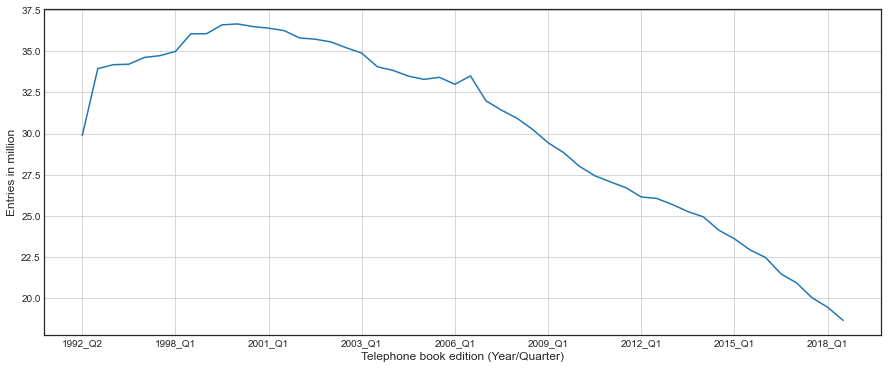

In [203]:
# Visualize total number of entries by collection (year and quarter)
plt.style.use('seaborn-white')
# plt.title('Total number of entries per telephone book edition (1992 - 2018)', fontdict={'size':14})
plt.figure(figsize=(15,6))
plt.plot(x_axis, y_axis)
plt.xlabel('Telephone book edition (Year/Quarter)', fontdict={'size':12})
plt.ylabel('Entries in million', fontdict={'size':12})
plt.grid(True)
plt.xticks(x_axis[0::6])
plt.savefig('./figures/plt_total_number_entries.png')
plt.show()

### Multiple plots in one graph

###### Step 1/4: Load data

In [207]:
graph_data_df = pd.read_csv(r'./stats/incomplete_loc_info.csv')
graph_data_df

,collection,zips_incomplete,zips_none,city_none,city_one,zips_city_none,street_none,ac_none,zips_ac_none,city_ac_none,zips_city_ac_none,total,zips_city_street_none,complete_sets
0,1992_Q2,0,2905202.0,1461147.0,0.0,1461147.0,3711265.0,467299.0,327431.0,276056.0,276056.0,29874373.0,918271.0,23097776.0
1,1995_Q0,1229454,1487431.0,2022610.0,0.0,1487431.0,5076972.0,884744.0,537850.0,550897.0,537850.0,33945932.0,1487370.0,26598240.0
2,1996_Q0,1259179,1521192.0,2056870.0,0.0,1521192.0,5171040.0,935953.0,569000.0,581828.0,569000.0,34189903.0,1521152.0,26721903.0
3,1996_Q1,0,5195360.0,5195360.0,0.0,5195360.0,5194653.0,955010.0,770190.0,770190.0,770190.0,34218752.0,5194653.0,26733404.0
4,1997_Q1,1259583,1662285.0,1667569.0,0.0,1646713.0,5367448.0,1291068.0,783034.0,783766.0,782084.0,34630715.0,1646713.0,26836036.0
5,1997_Q3,1283171,1871315.0,1856222.0,0.0,1856222.0,5535788.0,1593245.0,992700.0,991725.0,991725.0,34737798.0,1856222.0,26695583.0
6,1998_Q1,1291744,2059562.0,2044956.0,0.0,2044956.0,5724789.0,1522921.0,865909.0,864927.0,864927.0,34996369.0,2044956.0,26688340.0
7,1998_Q3,1329832,2290742.0,2275863.0,0.0,2275863.0,6061139.0,1768229.0,851509.0,850449.0,850449.0,36070875.0,2275863.0,26887868.0
8,1999_Q1,1341745,2071894.0,2057246.0,0.0,2057246.0,5856821.0,1972250.0,609923.0,608757.0,608757.0,36071839.0,2057246.0,26736811.0
9,1999_Q3,2937348,1603769.0,2388364.0,0.0,1603762.0,6084177.0,279138.0,7024.0,23075.0,7024.0,36612030.0,1603762.0,27913589.0


###### Step 2/4: Assign x-axis (reference axis for all plots)

In [50]:
x_axis = graph_data_df.collection

###### Step 3/4: Assign multiple y-axes

In [208]:
# Create y-axes for incomplete location data
y_total = adapt_axis_values(graph_data_df.total, 1000000)
y_zips_none = adapt_axis_values(graph_data_df.zips_none, 1000000)
y_city_none = adapt_axis_values(graph_data_df.city_none, 1000000)
y_street_none = adapt_axis_values(graph_data_df.street_none, 1000000)
y_ac_none = adapt_axis_values(graph_data_df.ac_none, 1000000)
y_zips_incomplete = adapt_axis_values(graph_data_df.zips_incomplete, 1000000)
y_zips_city_none = adapt_axis_values(graph_data_df.zips_city_none, 1000000)
y_zips_ac_none = adapt_axis_values(graph_data_df.zips_ac_none, 1000000)
y_city_ac_none = adapt_axis_values(graph_data_df.city_none, 1000000)
y_zips_city_ac_none = adapt_axis_values(graph_data_df.zips_city_ac_none, 1000000)
y_zips_city_street_none = adapt_axis_values(graph_data_df.zips_city_street_none, 1000000)

###### Step 4/4: Setup plot

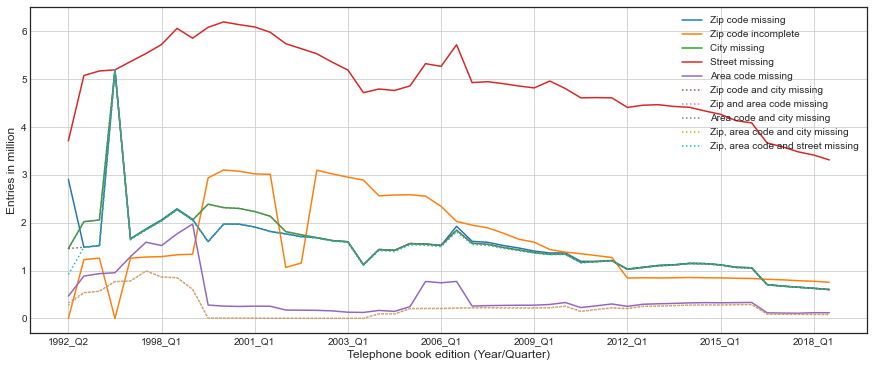

In [210]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15,6))

# plt.plot(x_axis, y_total, label='Total')
plt.plot(x_axis, y_zips_none, label='Zip code missing')
plt.plot(x_axis, y_zips_incomplete, label='Zip code incomplete')
plt.plot(x_axis, y_city_none, label='City missing')
plt.plot(x_axis, y_street_none, label='Street missing')
plt.plot(x_axis, y_ac_none, label='Area code missing')
plt.plot(x_axis, y_zips_city_none, linestyle=':', label='Zip code and city missing')
plt.plot(x_axis, y_zips_ac_none, linestyle=':', label='Zip and area code missing')
plt.plot(x_axis, y_city_ac_none, linestyle=':', label='Area code and city missing')
plt.plot(x_axis, y_zips_city_ac_none, linestyle=':', label='Zip, area code and city missing')
plt.plot(x_axis, y_zips_city_street_none, linestyle=':', label='Zip, area code and street missing')

plt.xlabel('Telephone book edition (Year/Quarter)', fontdict={'size':12})
plt.ylabel('Entries in million', fontdict={'size':12})
plt.legend()
plt.grid(True)
# list comprehension - get every 6th entry of list
plt.xticks(x_axis[0::6])
plt.savefig('./figures/plt_incomplete_loc_data.png')
plt.show()

#### Complete examples

In [14]:
graph_data_df = pd.read_csv(r'./stats/abbreviated_names.csv')
graph_data_df

,collection,fn_one,fn_one_dot,fn_none,fn_ln_none,ln_none,ln_one,ln_one_dot,total
0,1992_Q2,227,1943563,3147863.0,894419.0,894910.0,308.0,338.0,29874373.0
1,1995_Q0,108,2225041,4095130.0,1470004.0,1470593.0,354.0,154.0,33945932.0
2,1996_Q0,109,2229484,4135597.0,1499613.0,1500192.0,352.0,154.0,34189903.0
3,1996_Q1,106,2224907,4143945.0,1507692.0,1508263.0,342.0,116.0,34218752.0
4,1997_Q1,82,2165442,4286191.0,1618826.0,1619403.0,324.0,97.0,34630715.0
5,1997_Q3,85,2130247,4485546.0,1666754.0,1667377.0,297.0,102.0,34737798.0
6,1998_Q1,96,2108729,4704795.0,1884246.0,1884950.0,288.0,108.0,34996369.0
7,1998_Q3,114,2091444,5326020.0,2079914.0,2080745.0,275.0,101.0,36070875.0
8,1999_Q1,122,2046452,5149321.0,1843717.0,1844472.0,261.0,99.0,36071839.0
9,1999_Q3,193,1985407,5382932.0,2064938.0,2065590.0,204.0,96.0,36612030.0


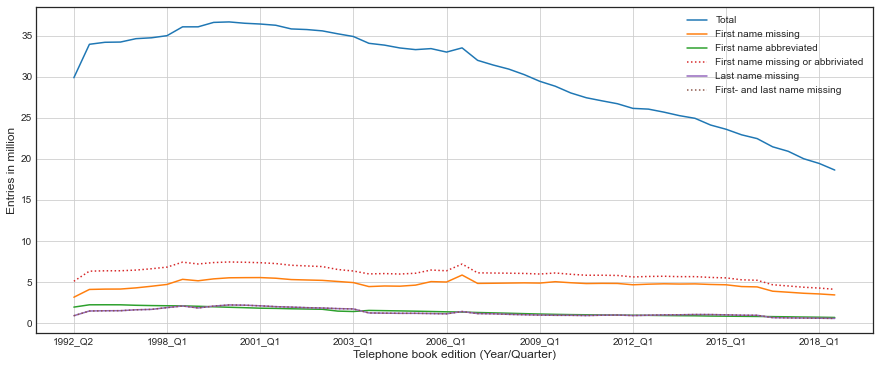

In [211]:
# Complete Run to create abbreviated names plot
graph_data_df = pd.read_csv(r'./stats/abbreviated_names.csv')

# Define x-axis
x_axis = graph_data_df.collection

# Create y-axes for abbriviated_names.csv
y_total = adapt_axis_values(graph_data_df.total, 1000000)
y_fn_none = adapt_axis_values(graph_data_df.fn_none, 1000000)
y_fn_one = adapt_axis_values((graph_data_df.fn_one + graph_data_df.fn_one_dot), 1000000)
y_fn_none_one = adapt_axis_values((graph_data_df.fn_none + graph_data_df.fn_one + graph_data_df.fn_one_dot), 1000000)
# y_fn_one_dot = adapt_axis_values(graph_data_df.fn_one_dot, 1000000)
y_fn_ln_none = adapt_axis_values(graph_data_df.fn_ln_none, 1000000)
y_ln_none = adapt_axis_values(graph_data_df.ln_none, 1000000)
y_ln_one = adapt_axis_values((graph_data_df.ln_one + graph_data_df.ln_one_dot), 1000000)
# y_ln_one_dot = adjust_axis_values(graph_data_df.ln_one_dot, 1000000)

plt.style.use('seaborn-white')
plt.figure(figsize=(15,6))

plt.plot(x_axis, y_total, label='Total')
plt.plot(x_axis, y_fn_none, label='First name missing')
plt.plot(x_axis, y_fn_one, label='First name abbreviated')
plt.plot(x_axis, y_fn_none_one, linestyle=':', label='First name missing or abbriviated')
# plt.plot(x_axis, y_fn_one_dot, label='One letter + \'.\' firstname')
plt.plot(x_axis, y_ln_none, label='Last name missing')
# plt.plot(x_axis, y_ln_one, label='One letter lastname')
plt.plot(x_axis, y_fn_ln_none, linestyle=':', label='First- and last name missing')
# plt.plot(x_axis, y_ln_one_dot, label='One letter + \'.\' lastname')

plt.xlabel('Telephone book edition (Year/Quarter)', fontdict={'size':12})
plt.ylabel('Entries in million', fontdict={'size':12})
plt.legend()
plt.grid(True)
plt.xticks(x_axis[0::6])
plt.savefig('./figures/plt_abbreviated_names.png')
plt.show()